In [1]:
import gensim
import pickle
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import font_manager as fm, rcParams
import matplotlib.font_manager as font_manager

from neurotools.io.gdrive import download_sheets_doc
from neurotools.io.files import load_embedding_model
from neurotools.language.simple_tokenizer import SimpleTokenizer
from itertools import product
from sklearn.externals import joblib
from ast import literal_eval
%matplotlib inline

In [2]:
from nltk import WordNetLemmatizer

## LOAD EMBEDDING AND DIMENSIONS

In [425]:
emb, word2rank_dict = load_embedding_model('005_en_in_commoncrawl_v1_20180330.bin')

In [426]:
cutoff = round((1/5)*len(word2rank_dict))

In [427]:
def get_average_vector(words, emb):
    """
        Average the word vectors of a list of words.
    """
    words_in_emb = [emb[word] for word in words if word in emb.vocab.keys()]
    total = np.sum(words_in_emb, axis=0)
    count = len(words_in_emb)
    return total / count

In [428]:
tokenizer = SimpleTokenizer('en')

Extra characters read for en
Stopwords set read for en
Lemma lookup read for en


In [429]:
def get_average_vector_of_dim_phrases(phrases):
    return np.array([get_average_vector(words, emb) for words in [tokenizer.tokenize(x) for x in phrases]]).mean(axis=0)

In [430]:
brand_purpose = ['loyalty', 'being genuine', 'openness', 'playful', 'friendly', 'approachable']
brand_myth = ['brotherhood']
product_ingredients = ['golden liquid', 'malty flavour', 'smooth', 'bitter', 'sweet', 'mouth coating', 'warm', 'light']
product_benefits = ['refreshing', 'everyday drink', 'don’t tire of the taste', 'goes well with food', 'rich', 'clean', 'crisp', 'confident']

In [431]:
claim_dims = pd.DataFrame(list(zip(['brand_purpose', 'brand_myth', 'product_ingredients', 'product_benefits'], [str(brand_purpose), str(brand_myth), str(product_ingredients), str(product_benefits)])))
claim_dims.columns = ['Dimension', 'Content']
claim_dims['Content'] = claim_dims['Content'].map(literal_eval)

In [432]:
claim_dims['wv'] = claim_dims['Content'].map(get_average_vector_of_dim_phrases)

In [433]:
claim_dims

,Dimension,Content,wv
0,brand_purpose,"[loyalty, being genuine, openness, playful, fr...","[-0.4050728, -0.51448447, 0.25315142, -0.96368..."
1,brand_myth,[brotherhood],"[-2.3176508, 0.38360557, 0.47491163, 1.0831361..."
2,product_ingredients,"[golden liquid, malty flavour, smooth, bitter,...","[-0.7164757, 2.0633802, -1.1426202, -0.5724804..."
3,product_benefits,"[refreshing, everyday drink, don’t tire of the...","[0.6288444, 2.3271506, -0.5007271, -0.48531783..."


In [473]:
original = ['No1 Yaari ka No1 Spirit',
'100% Grain Hi Hai Original Ki Pehchaan',
'Blended with imported scotch and Indian grain spirit',
'100% Grain 100% Delight 100% Yaari',
'yaari made richer']

In [474]:
claims = pd.DataFrame(original)
claims.columns = ['claim']

In [475]:
claims['tokens'] = claims['claim'].map(tokenizer.tokenize)

In [476]:
claims

,claim,tokens
0,No1 Yaari ka No1 Spirit,"[yaari, ka, spirit]"
1,100% Grain Hi Hai Original Ki Pehchaan,"[grain, hello, hai, original, ki, pehchaan]"
2,Blended with imported scotch and Indian grain ...,"[blend, import, scotch, indian, grain, spirit]"
3,100% Grain 100% Delight 100% Yaari,"[grain, delight, yaari]"
4,yaari made richer,"[yaari, rich]"


In [477]:
# claims.iloc[1,1] = ['percent', 'grain', 'hello', 'hai', 'original', 'ki', 'pehchaan']
# claims.iloc[3,1] = ['percent', 'grain', '100', 'percent', 'delight', '100', 'percent', 'yaari']

In [478]:
claims['wv'] = claims['tokens'].map(lambda x: get_average_vector(x, emb))

In [479]:
tokens = set(claims['tokens'].values.sum())

In [480]:
w2r = dict(zip([x for x in tokens if x in emb.vocab], [word2rank_dict[x] for x in tokens if x in emb.vocab]))
w2r = pd.qcut(pd.Series(w2r), 3, [0,1,2])

In [481]:
claims['rank'] = claims['tokens'].map(lambda words: np.round(np.array([w2r[word] for word in words if word in w2r.keys()]).mean()))

In [482]:
def cosine_similarity(a,b):
    """
        Compute the cosine similarity of a and b.
    """
    return np.dot(a,b) / ( (np.dot(a,a) **.5) * (np.dot(b,b) ** .5) )

In [483]:
def get_similarity_with_dimensions(row, dims):
    """
        Get similarity of row's word vector and every dimension.
        row : row of the movie dataframe
        dimensions : dataframe containing Neuroflash dimensions
    """
    for k in range(dims['Dimension'].shape[0]):
        name = 'dim_' + str(dims['Dimension'].iloc[k])
        # define a new column for the cosine similarity of dimension k and the post text
        row[name] = cosine_similarity(row['wv'], dims['wv'].iloc[k])
    return row

In [706]:
def sum_over_dimensions(words_df, dims, use_nf):
    df = words_df.apply(lambda x: get_similarity_with_dimensions(x, dims), axis=1)
    if not use_nf:
        filt = ['dim_brand_purpose', 'dim_brand_myth', 'dim_product_ingredients', 'dim_product_benefits']
    else:
        filt = ['dim_appealing', 'dim_innovative', 'dim_winner', 'dim_evolved']        
    filt.reverse()
    labels = ['claim', 'rank'] + filt + ['sum_over_dims']
    sum_df = pd.concat([df[['claim', 'rank']], df[filt], df[filt].sum(axis=1)], axis=1)
    sum_df.columns = labels
    return sum_df.set_index('claim')

In [707]:
# dim_labels = ['brand purpose', 'brand myth', 'product ingredients', 'product benefits']
dim_labels = ['appealing', 'innovative', 'winner', 'evolved']

In [708]:
clustered = pd.read_csv('csv/clustered_dims.csv')
clustered['wv'] = clustered['wv'].map(literal_eval)
clustered['Dimension'] = clustered['Dimension'].str[3:]
clustered['Dimension'] = ['appealing', 'innovative', 'winner', 'evolved']

In [812]:
# cols = list(plt.cm.tab20.colors[0:len(dim_labels)]) + list(plt.cm.tab20b.colors[0:len(dim_labels)])
# random.seed(3)
# random.shuffle(cols)
cols = ['#DCEDA0',
        '#B3DFE5',
        '#FFEFA4',
        '#FFC9F5',
        '#86A644',
        '#44C7D2',
        '#FFDD48',
        '#FE65D9',
        '#F39E23',
        '#DC2C3D']
colors = dict(zip(['brand purpose', 'brand myth', 'product ingredients', 'product benefits','appealing', 'innovative', 'winner', 'evolved', 'Diageo Combined Dimension', 'Neuro Flash Combined Dimension'], cols))

In [813]:
colors

{'Diageo Combined Dimension': '#F39E23',
 'Neuro Flash Combined Dimension': '#DC2C3D',
 'appealing': '#86A644',
 'brand myth': '#B3DFE5',
 'brand purpose': '#DCEDA0',
 'evolved': '#FE65D9',
 'innovative': '#44C7D2',
 'product benefits': '#FFC9F5',
 'product ingredients': '#FFEFA4',
 'winner': '#FFDD48'}

In [488]:
sum_over_dimensions(claims, claim_dims).index

Index(['No1 Yaari ka No1 Spirit', '100% Grain Hi Hai Original Ki Pehchaan',
       'Blended with imported scotch and Indian grain spirit',
       '100% Grain 100% Delight 100% Yaari', 'yaari made richer'],
      dtype='object', name='claim')

In [746]:
claim_to_nice = dict(zip(['No1 Yaari ka No1 Spirit', '100% Grain Hi Hai Original Ki Pehchaan',
       'Blended with imported scotch and Indian grain spirit',
       '100% Grain 100% Delight 100% Yaari', 'yaari made richer'], 
                     ['No1 Yaari ka \nNo1 Spirit', '100% Grain Hi Hai \nOriginal Ki Pehchaan',
        'Blended with imported scotch \nand Indian grain spirit', '100% Grain \n100% Delight \n100% Yaari', 'Yaari made richer']))

In [490]:
import matplotlib as mpl
mpl.rc('font',family='Open Sans')


In [491]:
sns.set_style("white")
sns.despine()

In [759]:
sum_over_dimensions(claims, claim_dims, False)[['rank', 'sum_over_dims']]

,rank,sum_over_dims
claim,,
No1 Yaari ka No1 Spirit,1.0,0.849918
100% Grain Hi Hai Original Ki Pehchaan,1.0,0.575442
Blended with imported scotch and Indian grain spirit,1.0,1.035391
100% Grain 100% Delight 100% Yaari,2.0,1.181701
yaari made richer,2.0,0.959613


In [808]:
concated = pd.concat([sum_over_dimensions(claims, claim_dims, False)[['rank', 'sum_over_dims']], sum_over_dimensions(claims, clustered, True)['sum_over_dims']], axis=1)

In [809]:
concated.columns = ['rank', 'dim_Diageo Combined Dimension', 'dim_Neuro Flash Combined Dimension']

In [810]:
concated['sum_over_dims'] = concated['dim_Diageo Combined Dimension'] + concated['dim_Neuro Flash Combined Dimension']

Index(['dim_Neuro Flash Combined Dimension', 'dim_Diageo Combined Dimension'], dtype='object')
Index(['Neuro Flash Combined Dimension', 'Diageo Combined Dimension'], dtype='object')


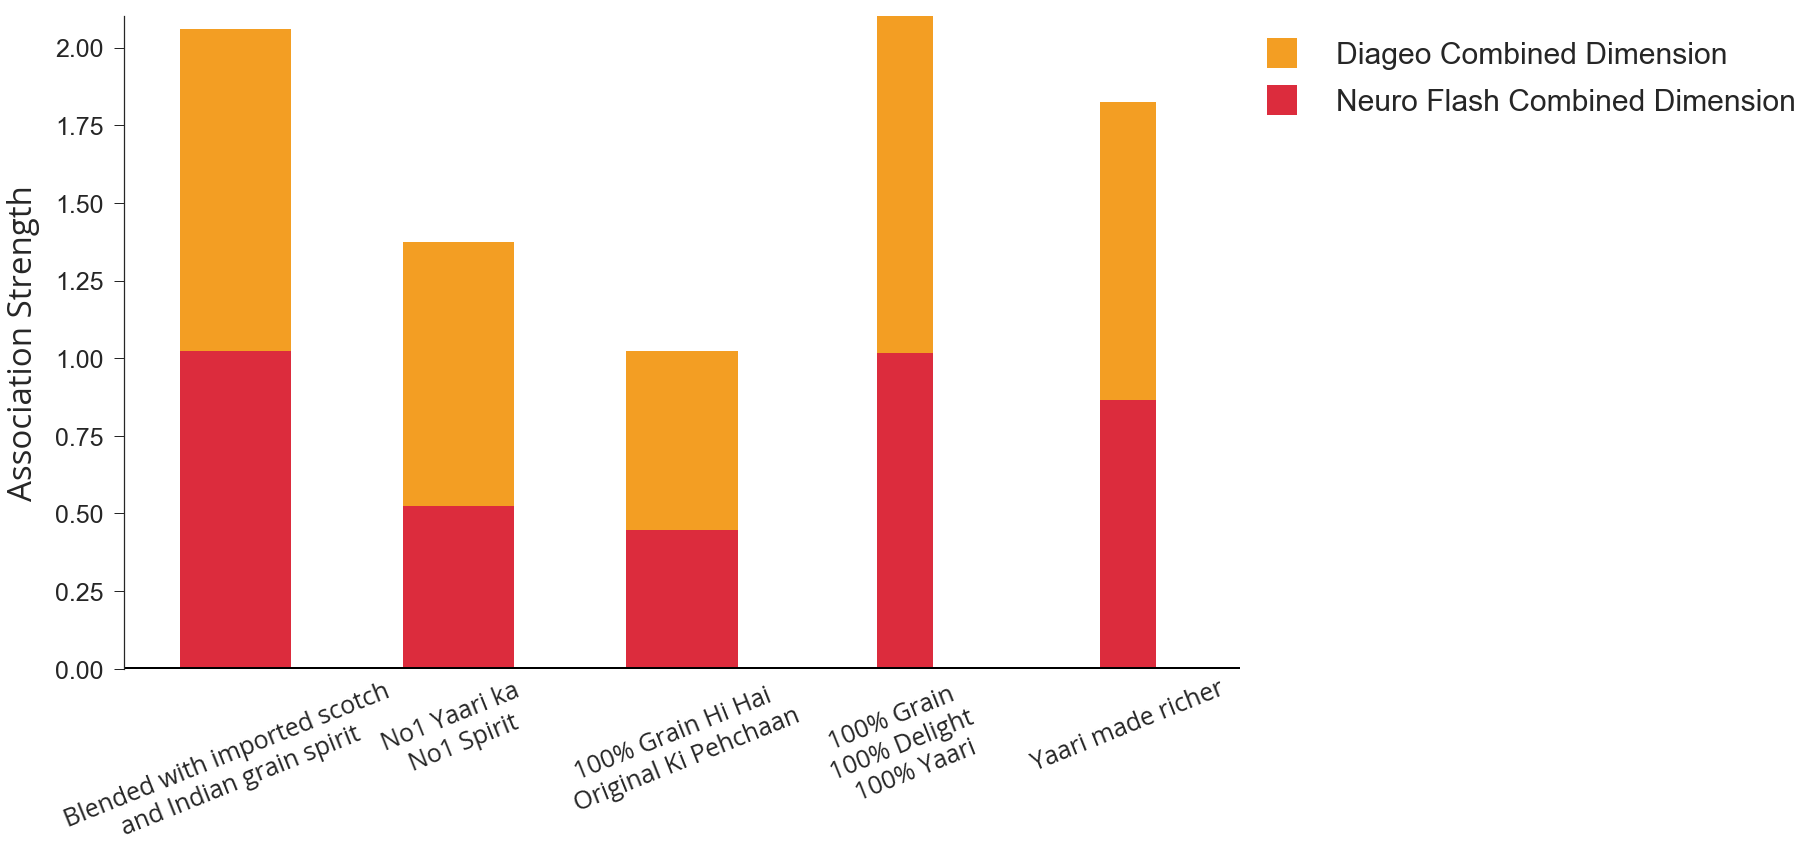

In [814]:
solo_bar_plot(concated, clustered, 'Overall', summed=True)

claim
No1 Yaari ka No1 Spirit                                 1.374394
100% Grain Hi Hai Original Ki Pehchaan                  1.023106
Blended with imported scotch and Indian grain spirit    2.059733
100% Grain 100% Delight 100% Yaari                      2.198318
yaari made richer                                       1.825058
Name: sum_over_dims, dtype: float64

In [823]:
concatedStacked = pd.concat([sum_over_dimensions(claims, claim_dims, False).iloc[:, 0:5], sum_over_dimensions(claims, clustered, True).iloc[:, 1:5], sum_over_dimensions(claims, claim_dims, False).iloc[:, 5] +  sum_over_dimensions(claims, clustered, True).iloc[:, 5]], axis=1)

In [824]:
concatedStacked

,rank,dim_product_benefits,dim_product_ingredients,dim_brand_myth,dim_brand_purpose,dim_evolved,dim_winner,dim_innovative,dim_appealing,sum_over_dims
claim,,,,,,,,,,
No1 Yaari ka No1 Spirit,1.0,0.197424,0.199890,0.194829,0.257776,0.074858,0.142498,0.027393,0.279726,1.374394
100% Grain Hi Hai Original Ki Pehchaan,1.0,0.216491,0.183630,0.072886,0.102436,0.087947,0.052086,0.126660,0.180970,1.023106
Blended with imported scotch and Indian grain spirit,1.0,0.377073,0.397361,0.046380,0.214577,0.351016,0.097303,0.207587,0.368436,2.059733
100% Grain 100% Delight 100% Yaari,2.0,0.440386,0.437821,0.044831,0.258663,0.223306,0.163507,0.143014,0.486790,2.198318
yaari made richer,2.0,0.417823,0.264402,0.093447,0.183940,0.177698,0.171472,0.069331,0.446943,1.825058


Index(['dim_evolved', 'dim_winner', 'dim_innovative', 'dim_appealing',
       'dim_product_benefits', 'dim_product_ingredients', 'dim_brand_myth',
       'dim_brand_purpose'],
      dtype='object')
Index(['evolved', 'winner', 'innovative', 'appealing', 'product benefits',
       'product ingredients', 'brand myth', 'brand purpose'],
      dtype='object')


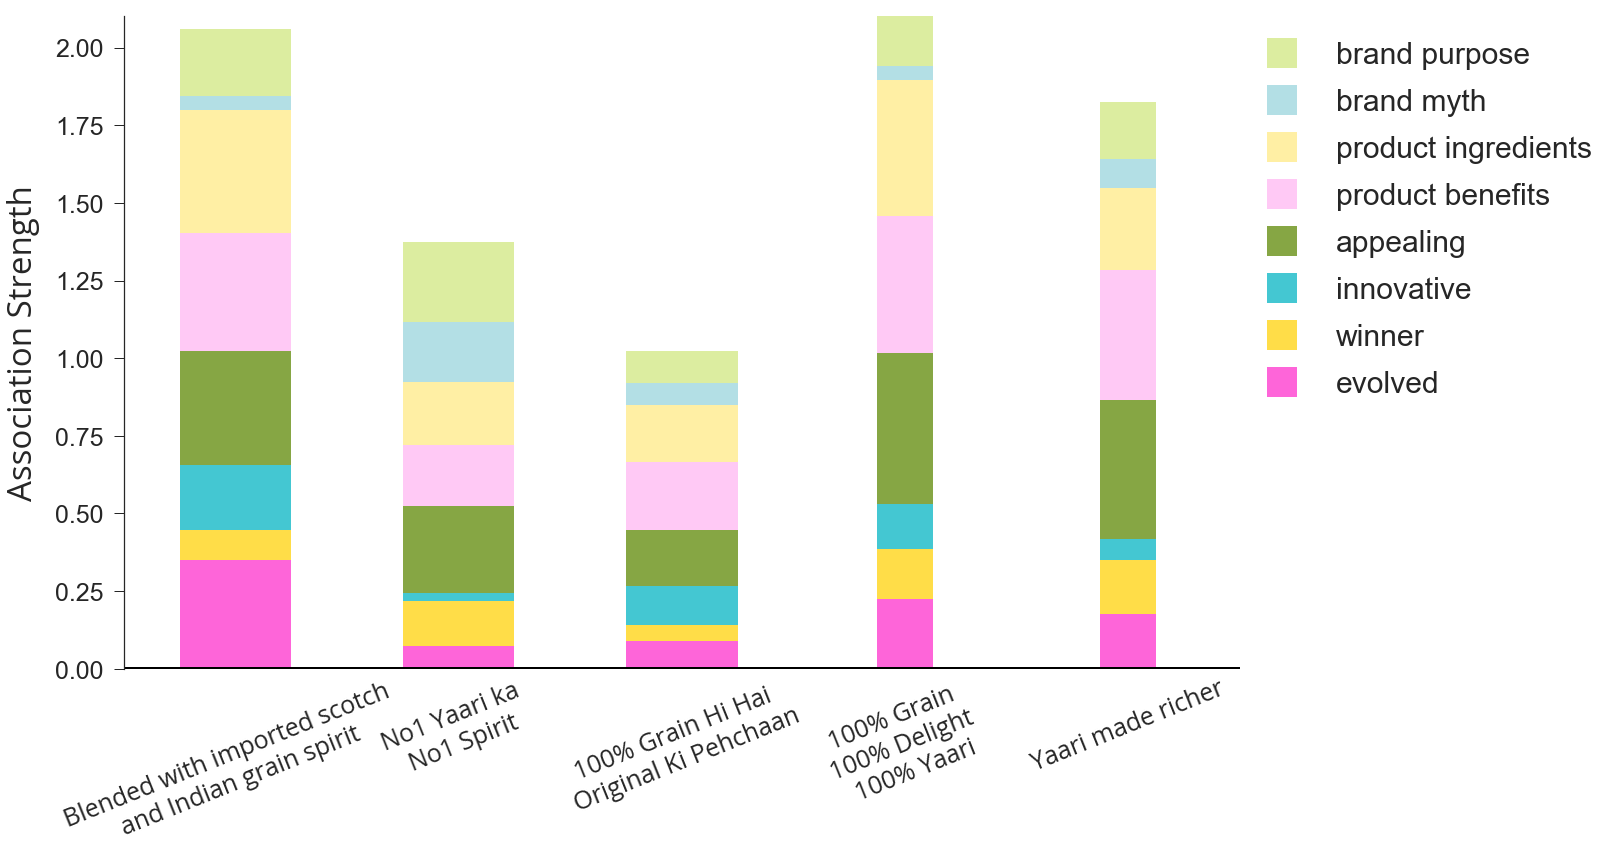

In [826]:
solo_bar_plot(concatedStacked, clustered, 'OverallStacked', summed=True)

In [ ]:
concated = pd.concat([sum_over_dimensions(claims, claim_dims, False)[['rank', 'sum_over_dims']], sum_over_dimensions(claims, clustered, True)['sum_over_dims']], axis=1)

In [982]:
def solo_bar_plot(words_df, dims, mode=4, summed=False, orig = True, use_nf = False):
    
    plt.figure(figsize=(20, 12))
    if not summed:
        dat = sum_over_dimensions(words_df, dims, use_nf)
    else:
        dat= words_df.sort_values('sum_over_dims', ascending=False).head(10).sort_values('rank', ascending=True)
    ranks = dat['rank']
    if mode == 'Overall':
        dat = dat.sort_values(['rank', 'sum_over_dims'], ascending=[True, False])
        filt = ['dim_Diageo Combined Dimension', 'dim_Neuro Flash Combined Dimension']  
    if mode == 'OverallStacked':
        dat = dat.sort_values(['rank', 'sum_over_dims'], ascending=[True, False])
        filt = ['dim_brand_purpose', 'dim_brand_myth', 'dim_product_ingredients', 'dim_product_benefits'] + ['dim_appealing', 'dim_innovative', 'dim_winner', 'dim_evolved']        
    if mode == 0 and not use_nf:
        dat = dat.sort_values(['rank', 'dim_brand_purpose'], ascending=[True, False])
        filt = ['dim_brand_purpose']
    elif mode == 1 and not use_nf:
        dat = dat.sort_values(['rank', 'dim_brand_myth'], ascending=[True, False])
        filt = ['dim_brand_myth']
    elif mode == 2 and not use_nf:
        dat = dat.sort_values(['rank', 'dim_product_ingredients'], ascending=[True, False])
        filt = ['dim_product_ingredients']
    elif mode == 3 and not use_nf:
        dat = dat.sort_values(['rank', 'dim_product_benefits'], ascending=[True, False])
        filt = ['dim_product_benefits']
    elif mode == 4 and not use_nf:
        dat = dat.sort_values(['rank', 'sum_over_dims'], ascending=[True, False])
        filt = ['dim_brand_purpose', 'dim_brand_myth', 'dim_product_ingredients', 'dim_product_benefits']
    if mode == 0 and use_nf:
        dat = dat.sort_values(['rank', 'dim_appealing'], ascending=[True, False])
        filt = ['dim_appealing']
    elif mode == 1 and use_nf:
        dat = dat.sort_values(['rank', 'dim_innovative'], ascending=[True, False])
        filt = ['dim_innovative']
    elif mode == 2 and use_nf:
        dat = dat.sort_values(['rank', 'dim_winner'], ascending=[True, False])
        filt = ['dim_winner']
    elif mode == 3 and use_nf:
        dat = dat.sort_values(['rank', 'dim_evolved'], ascending=[True, False])
        filt = ['dim_evolved']
    elif mode == 4 and use_nf:
        dat = dat.sort_values(['rank', 'sum_over_dims'], ascending=[True, False])
        filt = ['dim_appealing', 'dim_innovative', 'dim_winner', 'dim_evolved']   
    filt.reverse()
    dat = dat[filt]
    print(dat.columns)
#     dat = dat[['dim_dg_smart_thinking', 'dim_dg_malt', 'dim_dg_smoothness', 'dim_dg_richness']]
    dat.columns = [x[4:].replace('_', ' ') for x in dat.columns]
    print(dat.columns)
    dat.plot.bar(ax = plt.gca(), stacked=True, rot=17, fontsize=25, align='center', color=pd.Series(dat.columns).map(colors))
    plt.axhline(y=0, xmin=0, xmax=len(dat.columns), color='k', linewidth=4)
    plt.gca().grid(False) 
    sns.set_style("white")
    sns.despine()
    plt.gca().spines['bottom'].set_visible(False)
#     plt.gca().tick_params(bottom=False, left=True)
    plt.gca().tick_params(axis='y', length=10, which='major', pad=10)
    plt.xlabel('')
    if orig==True:
        if mode == 'Overall' or mode == 'OverallStacked':
            plt.ylim(0, 2.1)
        elif mode == 4:
            plt.ylim(0,1.1)            
        elif mode !=4 and use_nf:
            plt.ylim(0, 0.5)
        else:
            plt.ylim(0,0.44)        
#         plt.xticks(range(5),[claim_to_nice[x] for x in dat.index], fontname = 'Open Sans')
    else:
        plt.ylim(0, 2.8)
    patches = [plt.plot([],[], marker="s", ms=30, ls="", mec=None, color=colors[x], 
            label="{:s}".format(x))[0]  for x in dat.columns]
    plt.legend(handles=patches, loc=(1.0,0.9), fontsize=30, ncol=1, labelspacing=-2.5)
    if orig == False:

        for index, p in enumerate(plt.gca().patches):
            if index < 10:
                b = p.get_bbox()
                val = "{:+.2f}".format(b.y1 + b.y0)        
                plt.gca().annotate("{:s}".format(dat.index[index]), ((b.x0 - 0.38 + b.x1)/2 + 0.1, b.y1 + 0.9), fontsize = 25, rotation = 90)
        plt.xticks([])
    width_dict = {0: 0.75, 1: 0.5, 2: 0.25}
    for container in plt.gca().containers:
        for index,cc in enumerate(container.get_children()):
            old_width = cc.get_width() 
            new_width = width_dict[ranks.iloc[index]]
            diff = new_width - old_width
            plt.setp(cc, width = new_width)
            plt.setp(cc, x = cc.get_x() - 0.5*diff)
    plt.ylabel('Association Strength', fontsize = 33, fontname = 'Open Sans', fontweight='bold', labelpad=15)
    plt.savefig('plot/candidates_ranking_{}.png'.format(mode), bbox_inches = 'tight', transparent=True)        

Index(['dim_Neuro Flash Combined Dimension', 'dim_Diageo Combined Dimension'], dtype='object')
Index(['Neuro Flash Combined Dimension', 'Diageo Combined Dimension'], dtype='object')


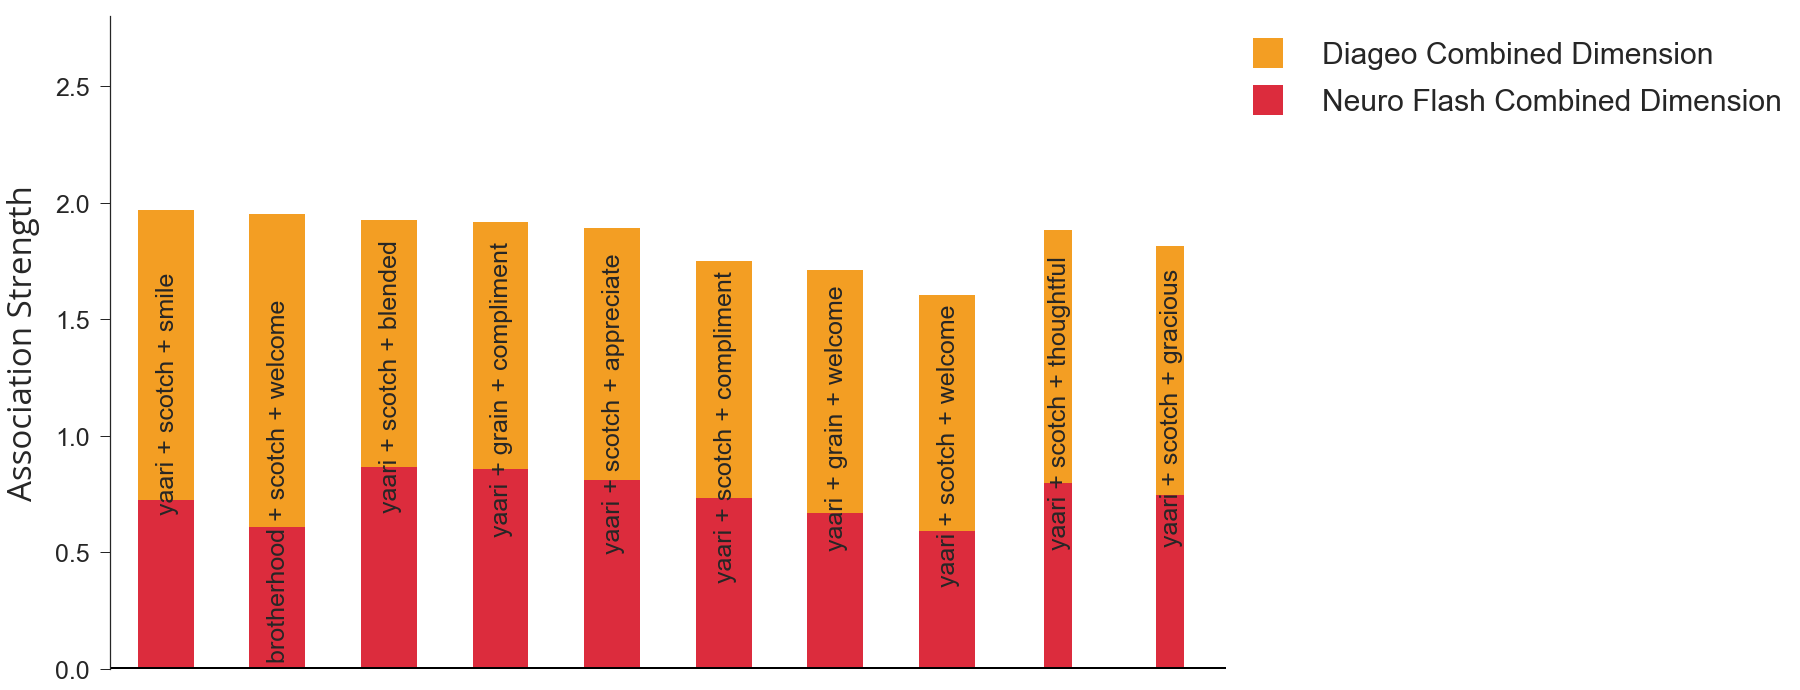

In [984]:
solo_bar_plot(ranked_candidate_stack.tail(10), clustered, 'Overall', orig = False, summed=True)

In [770]:
claims

,claim,tokens,wv,rank
0,No1 Yaari ka No1 Spirit,"[yaari, ka, spirit]","[0.5001866, 0.6641873, -1.4467922, -0.74694806...",1.0
1,100% Grain Hi Hai Original Ki Pehchaan,"[grain, hello, hai, original, ki, pehchaan]","[0.09837947, -1.1806262, -2.3887413, 1.5436647...",1.0
2,Blended with imported scotch and Indian grain ...,"[blend, import, scotch, indian, grain, spirit]","[1.7860141, 5.055079, -0.75358534, -0.79312783...",1.0
3,100% Grain 100% Delight 100% Yaari,"[grain, delight, yaari]","[0.54252845, 2.4519606, 0.40312514, -1.1404891...",2.0
4,yaari made richer,"[yaari, rich]","[-0.55660367, 2.235842, -0.23943049, -0.687845...",2.0


In [744]:
sum_over_dimensions(claims, clustered, True)

,rank,dim_evolved,dim_winner,dim_innovative,dim_appealing,sum_over_dims
claim,,,,,,
No1 Yaari ka No1 Spirit,1.0,0.074858,0.142498,0.027393,0.279726,0.524475
100% Grain Hi Hai Original Ki Pehchaan,1.0,0.087947,0.052086,0.126660,0.180970,0.447664
Blended with imported scotch and Indian grain spirit,1.0,0.351016,0.097303,0.207587,0.368436,1.024342
100% Grain 100% Delight 100% Yaari,2.0,0.223306,0.163507,0.143014,0.486790,1.016617
yaari made richer,2.0,0.177698,0.171472,0.069331,0.446943,0.865445


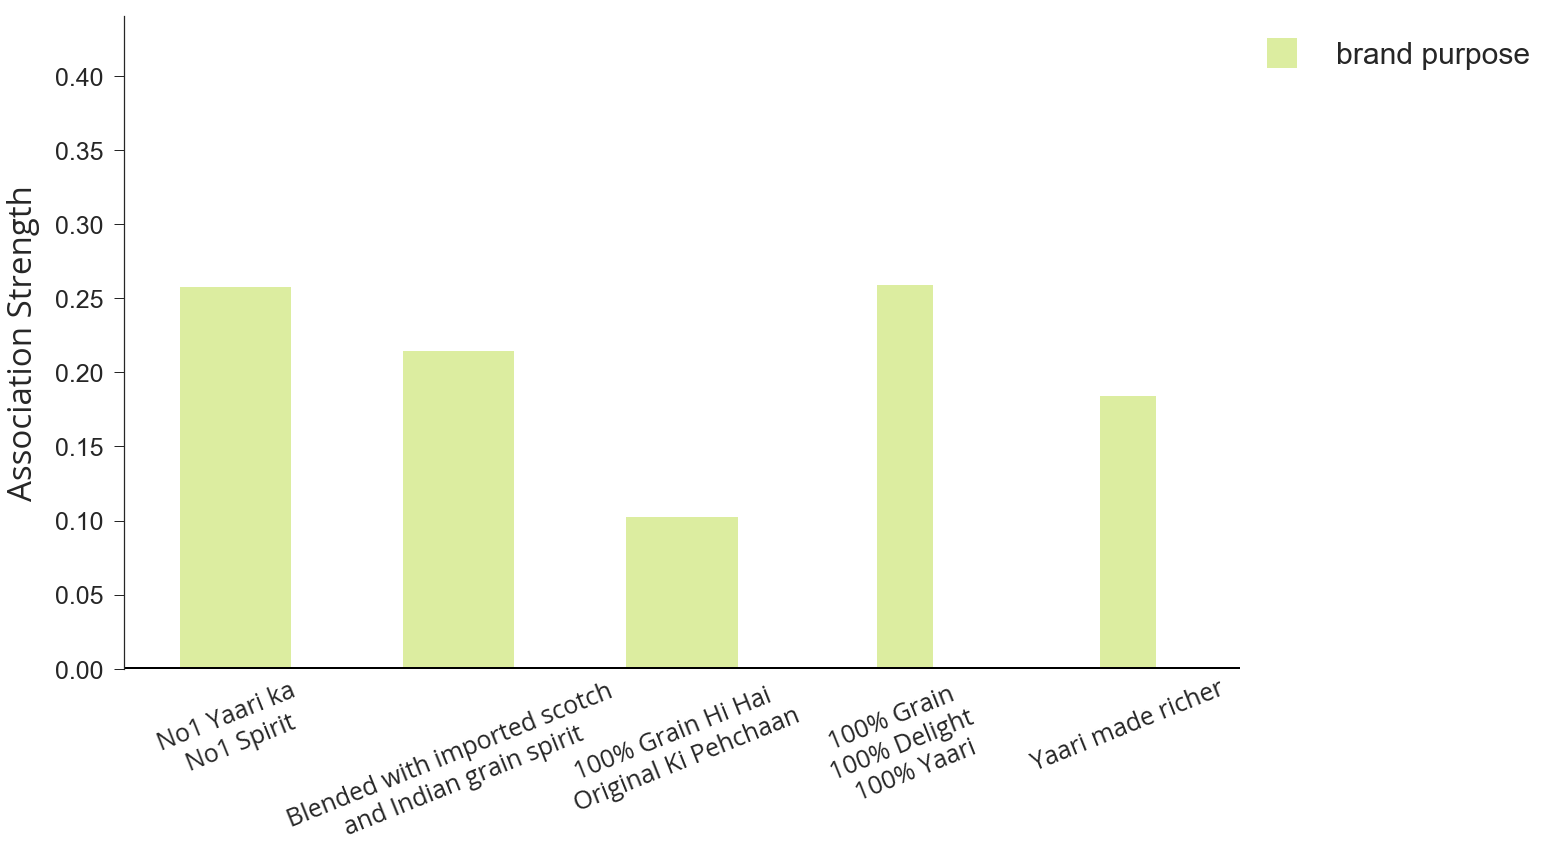

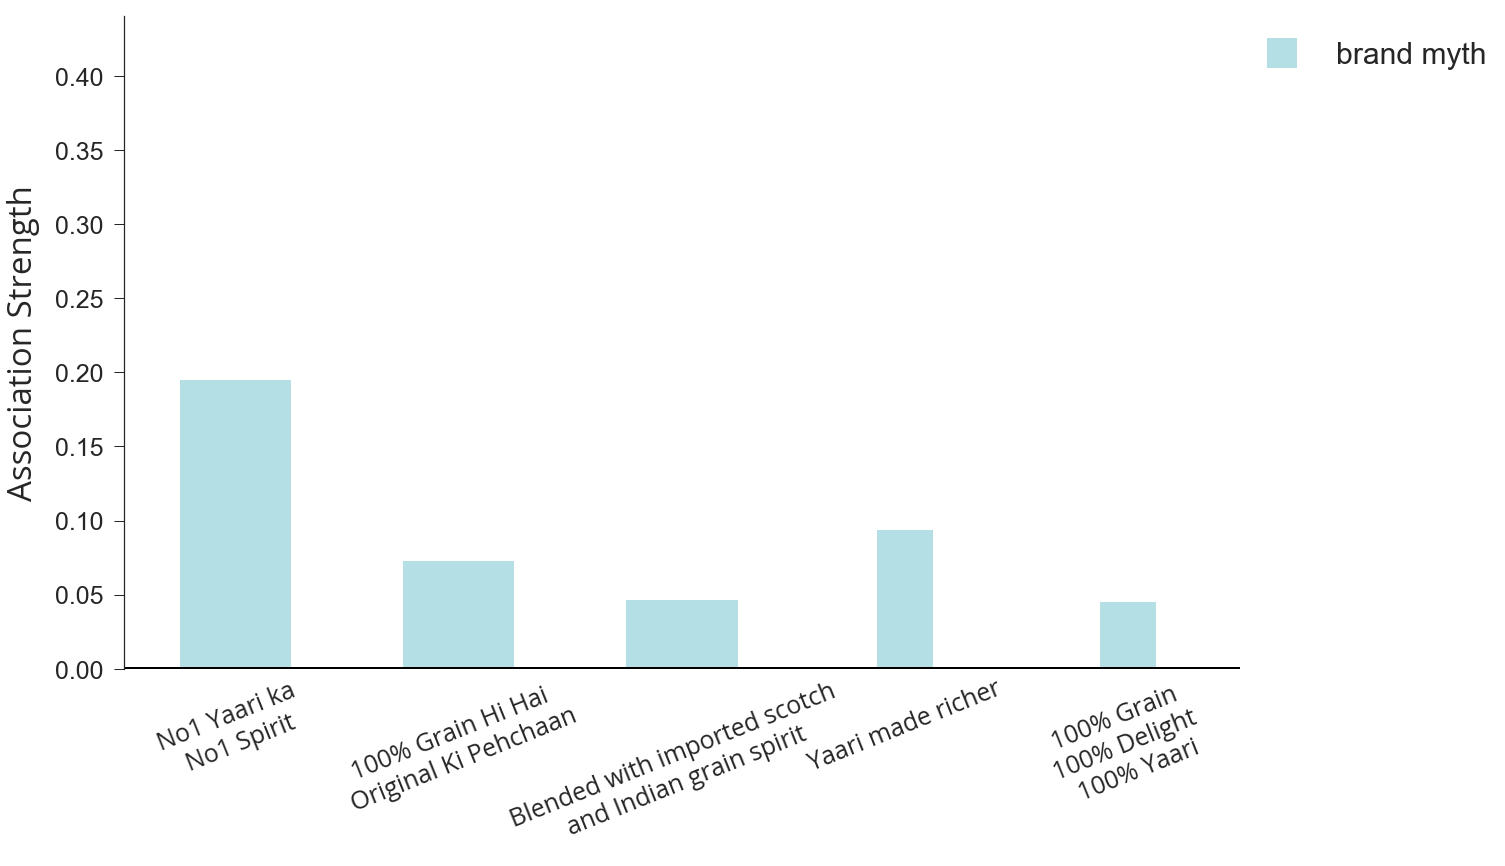

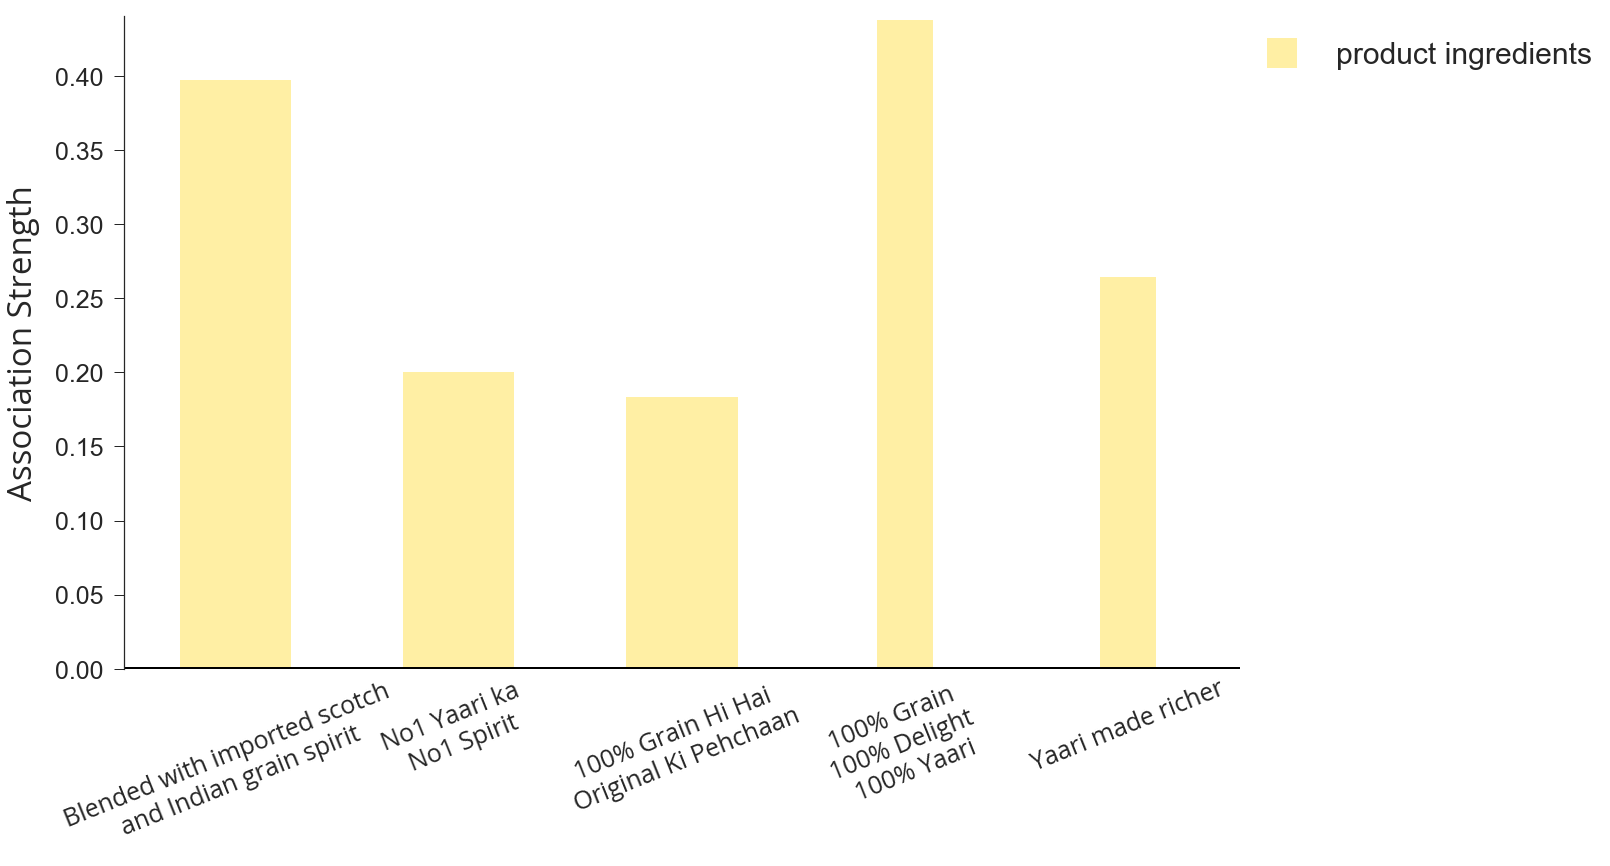

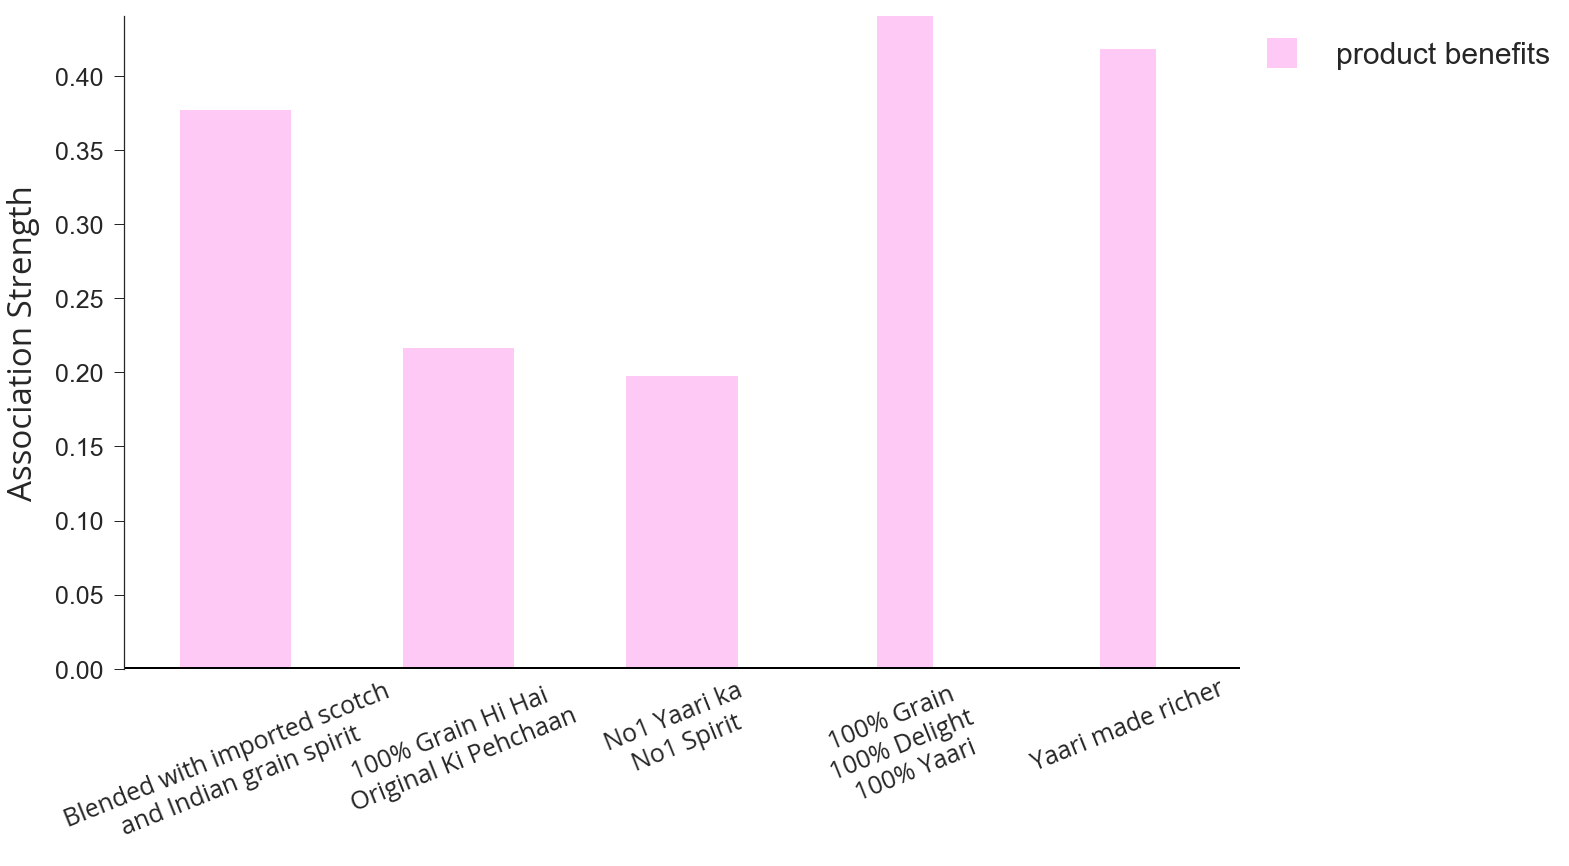

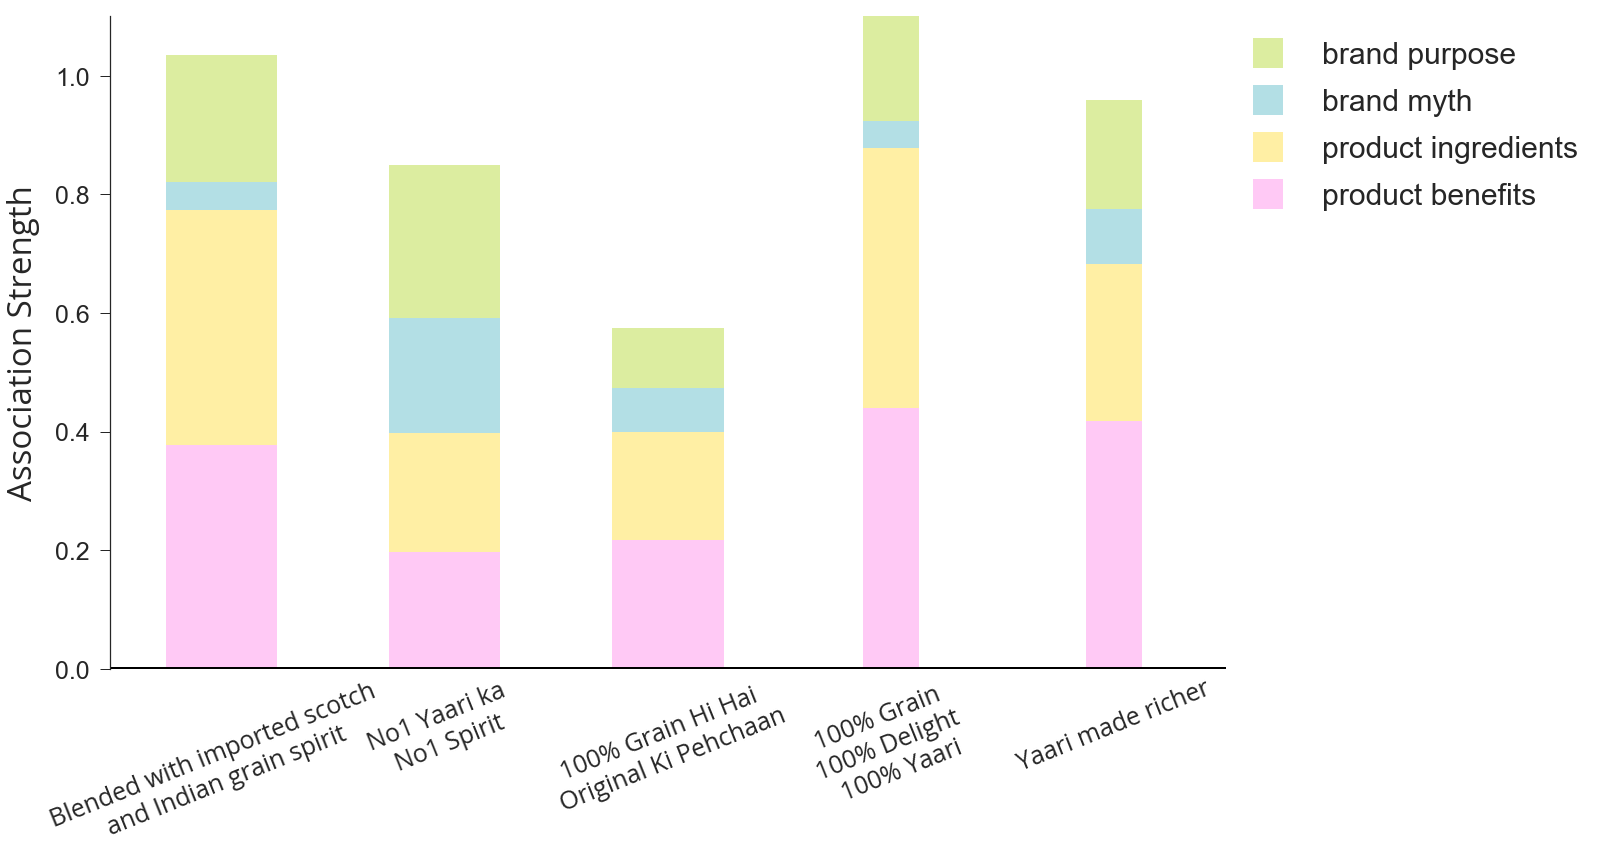

In [750]:
for i in range(5):
    solo_bar_plot(claims, claim_dims, i)

In [122]:
fpath = '/Desktop/OpenSans-Regular.ttf'

In [302]:
emb.similar_by_word('yaari')

[('shivanna', 0.5911937355995178),
 ('goli', 0.4880883991718292),
 ('dosti', 0.4822295010089874),
 ('saathiya', 0.4729905426502228),
 ('paanch', 0.46845123171806335),
 ('yaaran', 0.463734894990921),
 ('nibhana', 0.46331465244293213),
 ('aashiqui', 0.46309083700180054),
 ('kahani', 0.45741015672683716),
 ('jhoom', 0.454645037651062)]

In [571]:
ingredients = ['whisky', 'malt', 'whiskey', 'mix', 'scotch', 'fruity', 'malty', 'distill', 'mlx', 'starch']
flavors = ['blend', 'unique', 'charm', 'flavour', 'ensure', 'aroma', 'luxurious', 'diverse', 'sweet', 'generous']
profile = ['ensure', 'perfect', 'elegant', 'attractive', 'witty', 'gentle', 'comfortable', 'crisp', 'effortless', 'combination']

In [572]:
combinations = pd.DataFrame(list(product(profile, ingredients, flavors)), columns = ['smart_thinking', 'ingredient', 'taste'])

In [573]:
combinations['smart_thinking_wv'] = combinations['smart_thinking'].map(lambda x: get_average_vector([x], emb))
combinations['ingredient_wv'] = combinations['ingredient'].map(lambda x: get_average_vector([x], emb))
combinations['taste_wv'] = combinations['taste'].map(lambda x: get_average_vector([x], emb))
combinations['wv'] = (combinations['smart_thinking_wv'] + combinations['ingredient_wv'] + combinations['taste_wv']) / 3

In [574]:
combinations = combinations.apply(lambda x: get_similarity_with_dimensions(x, claim_dims), axis=1)
combinations = combinations.drop(columns=[x for x in combinations.columns if 'wv' in x])

In [575]:
combinations['label'] = combinations['smart_thinking'] + ' + ' + combinations['ingredient'] + ' + ' + combinations['taste']
combinations = combinations.set_index('label')

In [576]:
combinations['sum_over_dims'] = combinations[[x for x in combinations.columns if 'dim_' in x]].sum(axis=1)

In [577]:
combinations.sort_values('sum_over_dims', ascending=False).to_csv('csv/combs_no1.csv', index=False)

In [578]:
combinations

,smart_thinking,ingredient,taste,dim_brand_purpose,dim_brand_myth,dim_product_ingredients,dim_product_benefits,sum_over_dims
label,,,,,,,,
ensure + whisky + blend,ensure,whisky,blend,0.284083,0.012740,0.364231,0.447502,1.108556
ensure + whisky + unique,ensure,whisky,unique,0.367889,0.005266,0.274851,0.417392,1.065397
ensure + whisky + charm,ensure,whisky,charm,0.394205,0.004334,0.361209,0.447775,1.207523
ensure + whisky + flavour,ensure,whisky,flavour,0.283185,-0.029638,0.434499,0.474617,1.162664
ensure + whisky + ensure,ensure,whisky,ensure,0.263658,-0.029871,0.201445,0.338923,0.774155
ensure + whisky + aroma,ensure,whisky,aroma,0.264707,-0.015142,0.412622,0.449209,1.111397
ensure + whisky + luxurious,ensure,whisky,luxurious,0.304490,0.002550,0.286028,0.407475,1.000543
ensure + whisky + diverse,ensure,whisky,diverse,0.340689,0.007805,0.231507,0.394897,0.974898
ensure + whisky + sweet,ensure,whisky,sweet,0.283174,-0.034466,0.504203,0.465289,1.218199


Index(['product benefits', 'product ingredients', 'brand myth',
       'brand purpose'],
      dtype='object')


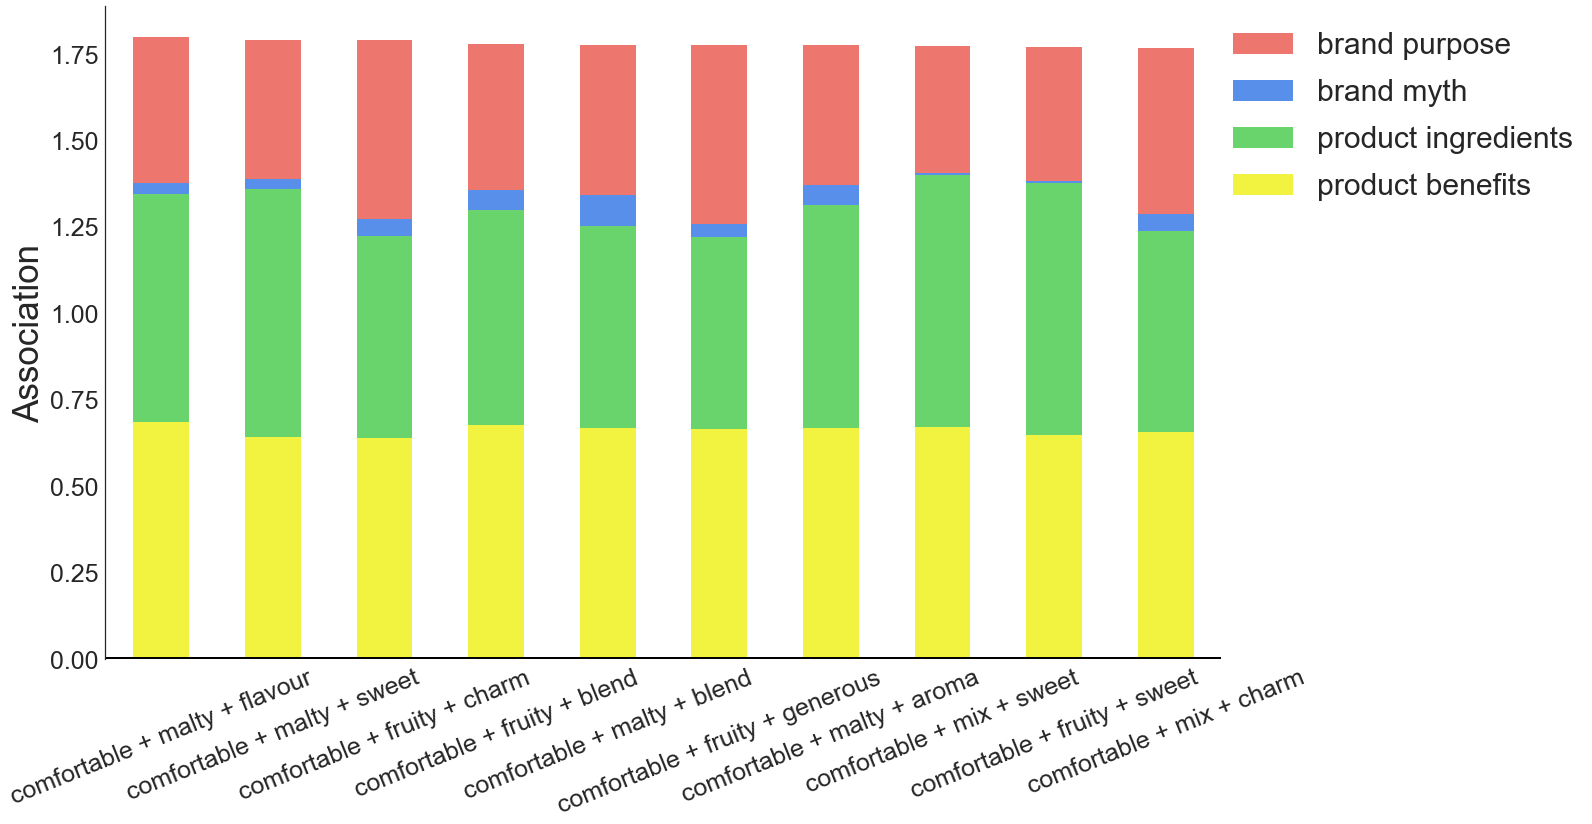

In [39]:
solo_bar_plot(combinations, claim_dims, True)

# from chart

In [514]:
def get_df_for_hook(words, tokenize=False):
    df = pd.DataFrame(list(words), columns = ['word'])
    df['word_token'] = df['word'].map(tokenizer.tokenize)
    df['wv'] = df['word_token'].map(lambda x: get_average_vector(x, emb)) # x is already list
    return df

In [516]:
valence_model = joblib.load('005_en_in_commoncrawl_v1_2018_0330.pkl')

In [515]:
def get_df_whisky_sim_and_valence_score(df):
#     df['used_in_graph'] = (df['word'].map(lambda x: x in pool)).astype(int)
    df['rank'] = df['word_token'].map(lambda x: word2rank_dict[x[0]])
    df['rank_quartile'] = pd.qcut(df['rank'], 3, [0,1,2])
    df['rank_in_top20%'] = (df['rank'] < cutoff).astype(int)
    df['sim_whisky'] = df['wv'].map(lambda x: cosine_similarity(x, emb['whisky']))
    df['valence'] = df['wv'].map(lambda x: valence_model.predict(x.reshape(1, -1))[0][0])
    df['sum_sim_valence'] = df['sim_whisky'] + df['valence']
    df = df.drop(['wv', 'word_token'], axis=1)
    df = df.sort_values('sum_sim_valence', ascending=False)
    return df


# Jonathan selected candidates

In [610]:
candidates = download_sheets_doc('1UDg79DPmV08UzkSgKnNSMpwvNxoqFamHX55Gcgv7HJs', has_column_labels=True)

In [611]:
candidates = candidates['Sheet1'][['brand_myth', 'product_ingredients', 'justbenefit']]

In [612]:
myth = get_df_for_hook(list(candidates['brand_myth'].values[:2]), tokenize=True)
ingredients = get_df_for_hook(list(candidates['product_ingredients'].values[:2]), tokenize=True)
benefits = get_df_for_hook(list(candidates['justbenefit'].values), tokenize=True)

In [613]:
myth = get_df_whisky_sim_and_valence_score(myth)
ingredients = get_df_whisky_sim_and_valence_score(ingredients)
benefits = get_df_whisky_sim_and_valence_score(benefits)

In [614]:
myth.to_csv('csv/no1_myth.csv', index=False)
ingredients.to_csv('csv/no1_ingredients.csv', index=False)
benefits.to_csv('csv/no1_benefits.csv', index=False)

In [615]:
myth_candidates = list(myth['word'].head(10).values)
ingredients_candidates = list(ingredients['word'].head(10).values)
benefits_candidates = list(benefits['word'].head(10).values)

In [631]:
candidates = list(set(myth_candidates + ingredients_candidates + benefits_candidates))

In [663]:
candidate_tokenized = list(pd.Series(candidates).map(lambda x: tokenizer.tokenize(x)[0]).values)

In [664]:
w2r_alt = dict(zip([x for x in candidate_tokenized if x in emb.vocab], [word2rank_dict[x] for x in candidate_tokenized if x in emb.vocab]))
w2r_alt = pd.qcut(pd.Series(w2r_alt), 3, [0,1,2])

In [838]:
combinations = pd.DataFrame(list(product(myth_candidates, ingredients_candidates, benefits_candidates)), columns = ['brand_myth', 'product_ingredients', 'product_benefits'])

In [857]:
combinations['tokens'] = (combinations['brand_myth'].map(lambda x: tokenizer.tokenize(x)[0]) + ' ' + combinations['product_ingredients'].map(lambda x: tokenizer.tokenize(x)[0]) + ' ' + combinations['product_benefits'].map(lambda x: tokenizer.tokenize(x)[0])).map(lambda x: x.split(' '))

In [858]:
combinations['rank'] = combinations['tokens'].map(lambda words: np.round(np.array([w2r_alt[word] for word in words if word in w2r_alt.keys()]).mean()))

In [859]:
combinations

,brand_myth,product_ingredients,product_benefits,brand_myth_wv,product_ingredients_wv,product_benefits_wv,wv,tokens,rank
0,yaari,scotch,welcome,"[0.6044201, 1.023147, 0.22996552, 0.20273983, ...","[0.9278203, 3.7112958, -0.3635818, -1.7889683,...","[2.588897, -3.2058458, 1.4046876, 0.6386789, 1...","[1.3737125, 0.5095323, 0.42369044, -0.31584987...","[yaari, scotch, welcome]",1.0
1,yaari,scotch,appreciate,"[0.6044201, 1.023147, 0.22996552, 0.20273983, ...","[0.9278203, 3.7112958, -0.3635818, -1.7889683,...","[2.1207116, -2.0033329, 2.026886, -4.9594254, ...","[1.2176507, 0.91036993, 0.63108987, -2.1818845...","[yaari, scotch, appreciate]",1.0
2,yaari,scotch,delight,"[0.6044201, 1.023147, 0.22996552, 0.20273983, ...","[0.9278203, 3.7112958, -0.3635818, -1.7889683,...","[-0.12369574, 0.9606187, 1.2864866, -3.2282155...","[0.46951488, 1.8983537, 0.3842901, -1.6048146,...","[yaari, scotch, delight]",1.0
3,yaari,scotch,wonderful,"[0.6044201, 1.023147, 0.22996552, 0.20273983, ...","[0.9278203, 3.7112958, -0.3635818, -1.7889683,...","[1.4338596, -1.3516454, 0.5490764, -5.5242686,...","[0.9887, 1.1275991, 0.1384867, -2.3701656, 0.3...","[yaari, scotch, wonderful]",1.0
4,yaari,scotch,blended,"[0.6044201, 1.023147, 0.22996552, 0.20273983, ...","[0.9278203, 3.7112958, -0.3635818, -1.7889683,...","[-1.4742926, 3.215057, 0.2324722, 2.373878, -0...","[0.019315919, 2.6498332, 0.03295197, 0.2625498...","[yaari, scotch, blend]",1.0
5,yaari,scotch,warmth,"[0.6044201, 1.023147, 0.22996552, 0.20273983, ...","[0.9278203, 3.7112958, -0.3635818, -1.7889683,...","[-2.4256666, 1.547293, 0.71644104, -2.2321124,...","[-0.29780874, 2.093912, 0.19427492, -1.2727803...","[yaari, scotch, warmth]",2.0
6,yaari,scotch,smile,"[0.6044201, 1.023147, 0.22996552, 0.20273983, ...","[0.9278203, 3.7112958, -0.3635818, -1.7889683,...","[-1.9885607, -3.74086, 1.0557734, -4.099683, 0...","[-0.15210676, 0.33119425, 0.3073857, -1.895303...","[yaari, scotch, smile]",1.0
7,yaari,scotch,thoughtful,"[0.6044201, 1.023147, 0.22996552, 0.20273983, ...","[0.9278203, 3.7112958, -0.3635818, -1.7889683,...","[0.36186278, -0.23509055, 1.6909668, -1.460267...","[0.63136774, 1.499784, 0.5191168, -1.0154986, ...","[yaari, scotch, thoughtful]",2.0
8,yaari,scotch,compliment,"[0.6044201, 1.023147, 0.22996552, 0.20273983, ...","[0.9278203, 3.7112958, -0.3635818, -1.7889683,...","[-0.6235363, 0.64529985, -1.4327509, -2.838933...","[0.30290136, 1.7932476, -0.52212244, -1.475053...","[yaari, scotch, compliment]",1.0
9,yaari,scotch,gracious,"[0.6044201, 1.023147, 0.22996552, 0.20273983, ...","[0.9278203, 3.7112958, -0.3635818, -1.7889683,...","[0.002325435, -2.7456827, -0.08669878, -2.8350...","[0.51152194, 0.66292, -0.073438354, -1.4737433...","[yaari, scotch, gracious]",2.0


In [839]:
combinations['brand_myth_wv'] = combinations['brand_myth'].map(lambda x: get_average_vector(tokenizer.tokenize(x), emb))
combinations['product_ingredients_wv'] = combinations['product_ingredients'].map(lambda x: get_average_vector(tokenizer.tokenize(x), emb))
combinations['product_benefits_wv'] = combinations['product_benefits'].map(lambda x: get_average_vector(tokenizer.tokenize(x), emb))
combinations['wv'] = (combinations['brand_myth_wv'] + combinations['product_ingredients_wv'] + combinations['product_benefits_wv'])/3

In [671]:
combinations = combinations.apply(lambda x: get_similarity_with_dimensions(x, claim_dims), axis=1)
combinations = combinations.drop(columns=[x for x in combinations.columns if 'wv' in x])

In [862]:
combinations['label'] = combinations['brand_myth'] + ' + ' + combinations['product_ingredients'] + ' + ' + combinations['product_benefits']
combinations = combinations.set_index('label')

In [673]:
combinations

,brand_myth,product_ingredients,product_benefits,tokens,rank,dim_brand_purpose,dim_brand_myth,dim_product_ingredients,dim_product_benefits
label,,,,,,,,,
yaari + scotch + welcome,yaari,scotch,welcome,"[yaari, scotch, welcome]",1.0,0.385506,0.196199,0.249302,0.180779
yaari + scotch + appreciate,yaari,scotch,appreciate,"[yaari, scotch, appreciate]",1.0,0.388374,0.140192,0.242781,0.311399
yaari + scotch + delight,yaari,scotch,delight,"[yaari, scotch, delight]",1.0,0.353906,0.148350,0.311079,0.298450
yaari + scotch + wonderful,yaari,scotch,wonderful,"[yaari, scotch, wonderful]",1.0,0.332914,0.149008,0.335770,0.365575
yaari + scotch + blended,yaari,scotch,blended,"[yaari, scotch, blend]",1.0,0.240286,0.133865,0.356583,0.331327
yaari + scotch + warmth,yaari,scotch,warmth,"[yaari, scotch, warmth]",2.0,0.388665,0.181935,0.429721,0.332926
yaari + scotch + smile,yaari,scotch,smile,"[yaari, scotch, smile]",1.0,0.399439,0.121588,0.386861,0.334693
yaari + scotch + thoughtful,yaari,scotch,thoughtful,"[yaari, scotch, thoughtful]",2.0,0.413377,0.114869,0.257682,0.297943
yaari + scotch + compliment,yaari,scotch,compliment,"[yaari, scotch, compliment]",1.0,0.360122,0.103173,0.271840,0.279606


In [674]:
combinations['sum_over_dims'] = combinations['dim_brand_myth'] + combinations['dim_product_ingredients'] + combinations['dim_product_benefits']

In [675]:
combinations

,brand_myth,product_ingredients,product_benefits,tokens,rank,dim_brand_purpose,dim_brand_myth,dim_product_ingredients,dim_product_benefits,sum_over_dims
label,,,,,,,,,,
yaari + scotch + welcome,yaari,scotch,welcome,"[yaari, scotch, welcome]",1.0,0.385506,0.196199,0.249302,0.180779,0.626281
yaari + scotch + appreciate,yaari,scotch,appreciate,"[yaari, scotch, appreciate]",1.0,0.388374,0.140192,0.242781,0.311399,0.694372
yaari + scotch + delight,yaari,scotch,delight,"[yaari, scotch, delight]",1.0,0.353906,0.148350,0.311079,0.298450,0.757878
yaari + scotch + wonderful,yaari,scotch,wonderful,"[yaari, scotch, wonderful]",1.0,0.332914,0.149008,0.335770,0.365575,0.850354
yaari + scotch + blended,yaari,scotch,blended,"[yaari, scotch, blend]",1.0,0.240286,0.133865,0.356583,0.331327,0.821775
yaari + scotch + warmth,yaari,scotch,warmth,"[yaari, scotch, warmth]",2.0,0.388665,0.181935,0.429721,0.332926,0.944581
yaari + scotch + smile,yaari,scotch,smile,"[yaari, scotch, smile]",1.0,0.399439,0.121588,0.386861,0.334693,0.843142
yaari + scotch + thoughtful,yaari,scotch,thoughtful,"[yaari, scotch, thoughtful]",2.0,0.413377,0.114869,0.257682,0.297943,0.670493
yaari + scotch + compliment,yaari,scotch,compliment,"[yaari, scotch, compliment]",1.0,0.360122,0.103173,0.271840,0.279606,0.654618


In [682]:
combinations['sum_over_dims'].sort_values(ascending=False)#.to_csv('csv/no1_ranking.csv')

label
brotherhood + grain + smile          1.446697
brotherhood + grain + warmth         1.439280
brotherhood + grain + wonderful      1.409529
brotherhood + grain + delight        1.357933
brotherhood + grain + thoughtful     1.356870
brotherhood + grain + blended        1.332346
brotherhood + grain + gracious       1.327908
brotherhood + grain + compliment     1.304155
brotherhood + scotch + warmth        1.291142
brotherhood + grain + appreciate     1.284749
brotherhood + scotch + smile         1.245371
brotherhood + scotch + wonderful     1.235988
brotherhood + scotch + blended       1.199899
brotherhood + scotch + delight       1.165175
brotherhood + scotch + gracious      1.134296
brotherhood + scotch + thoughtful    1.134236
brotherhood + scotch + compliment    1.116241
brotherhood + scotch + appreciate    1.113391
brotherhood + grain + welcome        1.088537
yaari + grain + warmth               1.077162
yaari + grain + smile                1.012302
yaari + grain + wonderful   

In [537]:
#combinations['sum_over_dimensions'].sort_values(ascending=False)

label
brotherhood + grain + smile          1.446697
brotherhood + grain + warmth         1.439280
brotherhood + grain + wonderful      1.409529
brotherhood + grain + delight        1.357933
brotherhood + grain + thoughtful     1.356870
brotherhood + grain + blended        1.332346
brotherhood + grain + gracious       1.327908
brotherhood + grain + compliment     1.304155
brotherhood + scotch + warmth        1.291142
brotherhood + grain + appreciate     1.284749
brotherhood + scotch + smile         1.245371
brotherhood + scotch + wonderful     1.235988
brotherhood + scotch + blended       1.199899
brotherhood + scotch + delight       1.165175
brotherhood + scotch + gracious      1.134296
brotherhood + scotch + thoughtful    1.134236
brotherhood + scotch + compliment    1.116241
brotherhood + scotch + appreciate    1.113391
brotherhood + grain + welcome        1.088537
yaari + grain + warmth               1.077162
yaari + grain + smile                1.012302
yaari + grain + wonderful   

,brand_myth,product_ingredients,product_benefits,tokens,rank,dim_brand_purpose,dim_brand_myth,dim_product_ingredients,dim_product_benefits,sum_over_dims
label,,,,,,,,,,
yaari + scotch + welcome,yaari,scotch,welcome,"[yaari, scotch, welcome]",1.0,0.385506,0.196199,0.249302,0.180779,0.626281
yaari + scotch + appreciate,yaari,scotch,appreciate,"[yaari, scotch, appreciate]",1.0,0.388374,0.140192,0.242781,0.311399,0.694372
yaari + scotch + delight,yaari,scotch,delight,"[yaari, scotch, delight]",1.0,0.353906,0.148350,0.311079,0.298450,0.757878
yaari + scotch + wonderful,yaari,scotch,wonderful,"[yaari, scotch, wonderful]",1.0,0.332914,0.149008,0.335770,0.365575,0.850354
yaari + scotch + blended,yaari,scotch,blended,"[yaari, scotch, blend]",1.0,0.240286,0.133865,0.356583,0.331327,0.821775
yaari + scotch + warmth,yaari,scotch,warmth,"[yaari, scotch, warmth]",2.0,0.388665,0.181935,0.429721,0.332926,0.944581
yaari + scotch + smile,yaari,scotch,smile,"[yaari, scotch, smile]",1.0,0.399439,0.121588,0.386861,0.334693,0.843142
yaari + scotch + thoughtful,yaari,scotch,thoughtful,"[yaari, scotch, thoughtful]",2.0,0.413377,0.114869,0.257682,0.297943,0.670493
yaari + scotch + compliment,yaari,scotch,compliment,"[yaari, scotch, compliment]",1.0,0.360122,0.103173,0.271840,0.279606,0.654618


Index(['product benefits', 'product ingredients', 'brand myth',
       'brand purpose'],
      dtype='object')


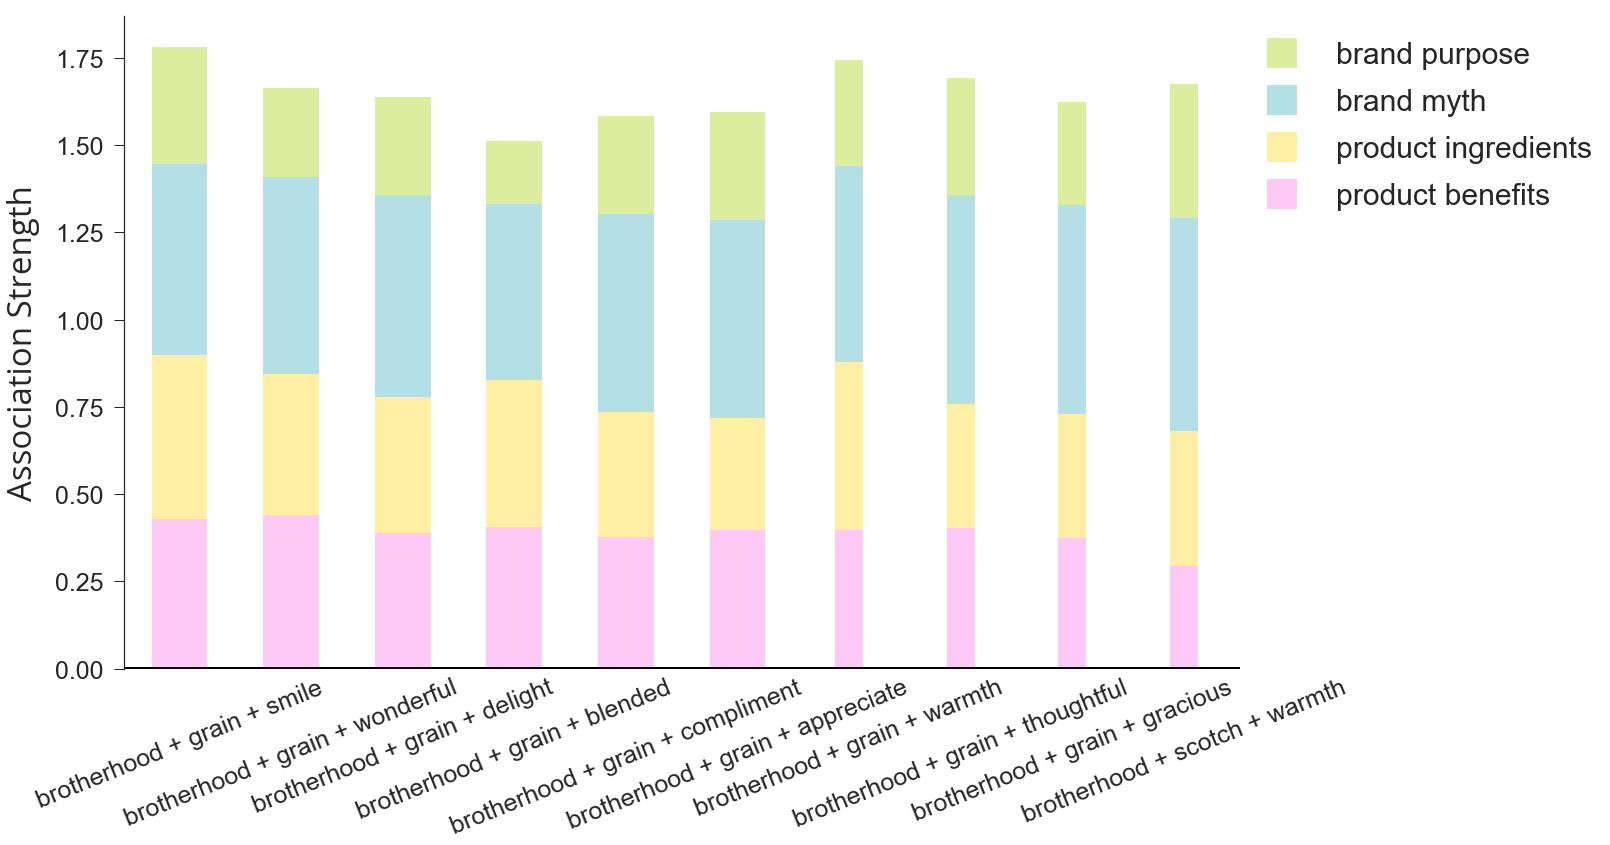

In [695]:
solo_bar_plot(combinations.sort_values(['rank', 'sum_over_dims'], ascending=[True, False]), claim_dims, 4, True, False)

In [697]:
clustered

,wv,Dimension
0,"[0.24479248775885656, 0.9547597502286618, -0.5...",appealing
1,"[-2.3206920623779297, 0.29747605323791504, -0....",innovative
2,"[-0.4082222580909729, 1.4663633108139038, -1.1...",winner
3,"[1.1638178825378418, 2.4766998291015625, 0.099...",evolved


In [832]:
all_dims = pd.concat([claim_dims[['Dimension', 'wv']], clustered[['Dimension', 'wv']]], axis=0, ignore_index=True)

In [883]:
combinations_all = combinations.apply(lambda x: get_similarity_with_dimensions(x, all_dims), axis=1)
combinations_all = combinations_all.drop(columns=[x for x in combinations.columns if 'wv' in x])

In [884]:
combinations_all['rank'] = combinations['rank']

In [885]:
combinations_all

,brand_myth,product_ingredients,product_benefits,tokens,rank,dim_brand_purpose,dim_brand_myth,dim_product_ingredients,dim_product_benefits,dim_appealing,dim_innovative,dim_winner,dim_evolved
label,,,,,,,,,,,,,
yaari + scotch + welcome,yaari,scotch,welcome,"[yaari, scotch, welcome]",1.0,0.385506,0.196199,0.249302,0.180779,0.243526,0.111034,0.133419,0.102928
yaari + scotch + appreciate,yaari,scotch,appreciate,"[yaari, scotch, appreciate]",1.0,0.388374,0.140192,0.242781,0.311399,0.377755,0.068601,0.179851,0.182151
yaari + scotch + delight,yaari,scotch,delight,"[yaari, scotch, delight]",1.0,0.353906,0.148350,0.311079,0.298450,0.405832,0.064021,0.232066,0.168982
yaari + scotch + wonderful,yaari,scotch,wonderful,"[yaari, scotch, wonderful]",1.0,0.332914,0.149008,0.335770,0.365575,0.436985,0.088729,0.203034,0.221487
yaari + scotch + blended,yaari,scotch,blended,"[yaari, scotch, blend]",1.0,0.240286,0.133865,0.356583,0.331327,0.325311,0.166082,0.083004,0.290231
yaari + scotch + warmth,yaari,scotch,warmth,"[yaari, scotch, warmth]",2.0,0.388665,0.181935,0.429721,0.332926,0.424324,0.129279,0.126649,0.210568
yaari + scotch + smile,yaari,scotch,smile,"[yaari, scotch, smile]",1.0,0.399439,0.121588,0.386861,0.334693,0.363718,0.057566,0.198256,0.106491
yaari + scotch + thoughtful,yaari,scotch,thoughtful,"[yaari, scotch, thoughtful]",2.0,0.413377,0.114869,0.257682,0.297943,0.374709,0.081670,0.126691,0.215127
yaari + scotch + compliment,yaari,scotch,compliment,"[yaari, scotch, compliment]",1.0,0.360122,0.103173,0.271840,0.279606,0.329706,0.049219,0.231937,0.123711


In [886]:
combinations_all['dim_Diageo Combined Dimension'] = combinations_all['dim_brand_purpose'] + combinations_all['dim_brand_myth'] + combinations_all['dim_product_ingredients'] + combinations_all['dim_product_benefits']
combinations_all['dim_Neuro Flash Combined Dimension'] = combinations_all['dim_appealing'] + combinations_all['dim_innovative'] + combinations_all['dim_winner'] + combinations_all['dim_evolved']

In [887]:
combinations_all['sum_over_dims'] = combinations_all['dim_Diageo Combined Dimension'] + combinations_all['dim_Neuro Flash Combined Dimension']

In [888]:
combinations_all['label'] = combinations_all['brand_myth'] + ' + ' + combinations_all['product_ingredients'] + ' + ' + combinations_all['product_benefits']
combinations_all = combinations_all.set_index('label')

In [889]:
candidatestack = combinations_all[['rank', 'dim_Diageo Combined Dimension', 'dim_Neuro Flash Combined Dimension', 'sum_over_dims']]

In [891]:
ranked_candidate_stack = candidatestack.sort_values('sum_over_dims', ascending=False)

In [902]:
ranked_candidate_stack.head(10)

,rank,dim_Diageo Combined Dimension,dim_Neuro Flash Combined Dimension,sum_over_dims
label,,,,
brotherhood + grain + warmth,2.0,1.743870,0.965581,2.709450
brotherhood + grain + wonderful,1.0,1.663628,1.045702,2.709330
brotherhood + grain + smile,1.0,1.780311,0.870135,2.650446
brotherhood + grain + thoughtful,2.0,1.692573,0.955636,2.648209
brotherhood + grain + delight,1.0,1.638675,0.996806,2.635480
brotherhood + scotch + warmth,2.0,1.675274,0.873159,2.548432
brotherhood + grain + appreciate,1.0,1.595285,0.927533,2.522818
brotherhood + scotch + wonderful,1.0,1.574383,0.928210,2.502593
brotherhood + grain + gracious,2.0,1.623191,0.875328,2.498518


Index(['dim_Neuro Flash Combined Dimension', 'dim_Diageo Combined Dimension'], dtype='object')
Index(['Neuro Flash Combined Dimension', 'Diageo Combined Dimension'], dtype='object')


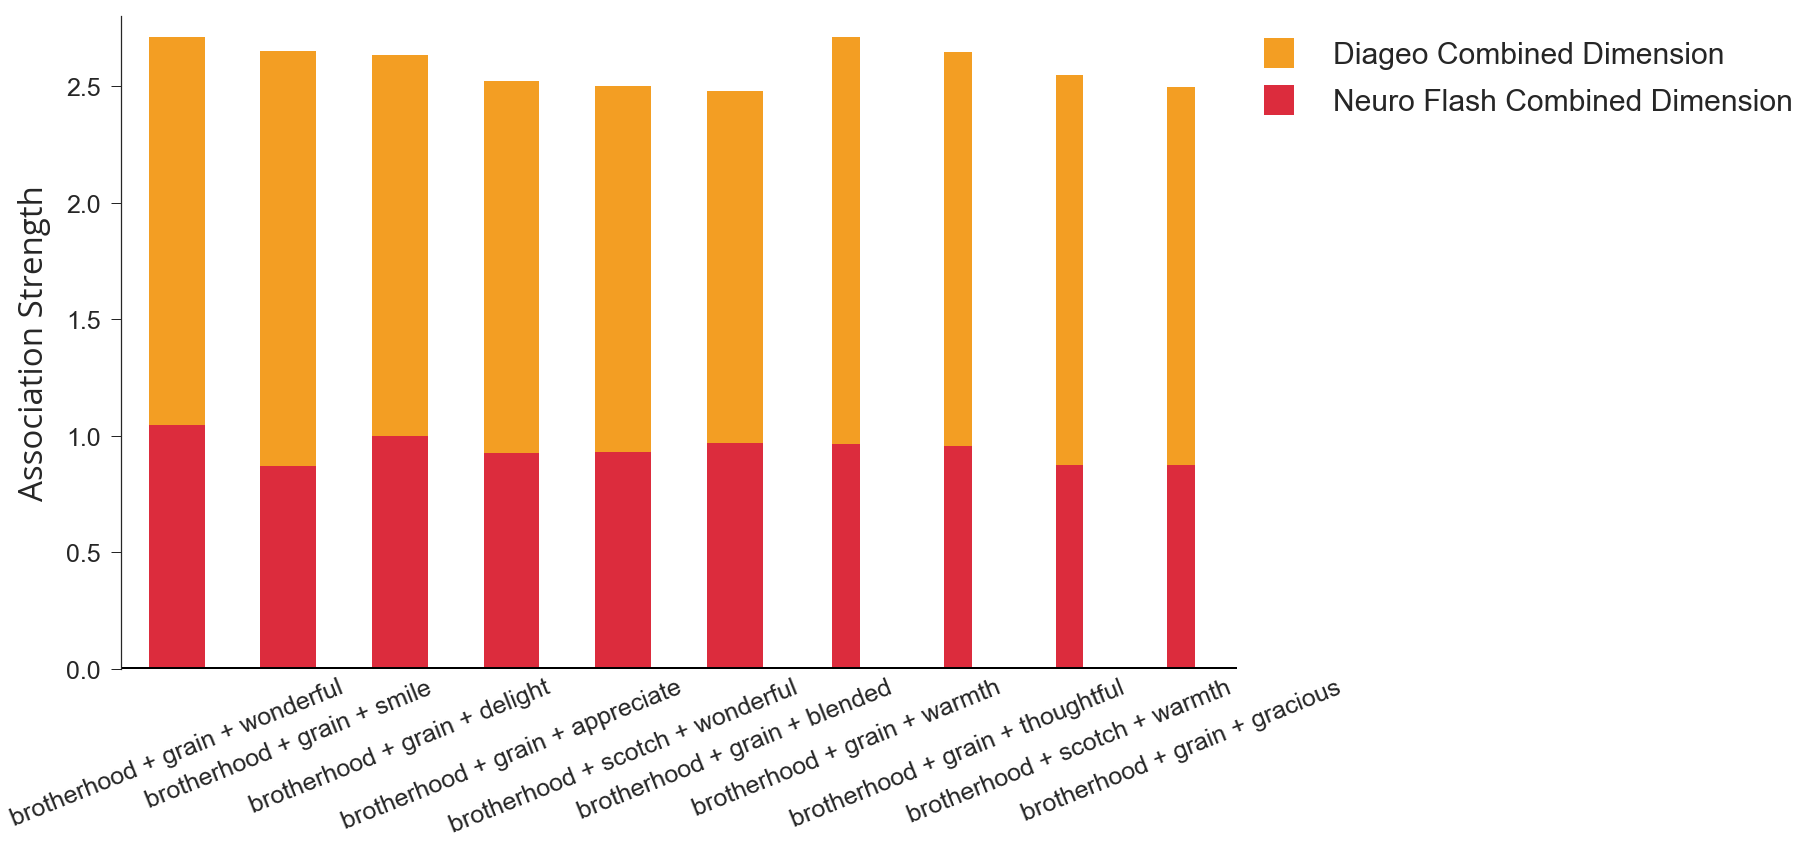

In [904]:
solo_bar_plot(ranked_candidate_stack.head(10), clustered, 'Overall', orig = False, summed=True)

Index(['dim_Neuro Flash Combined Dimension', 'dim_Diageo Combined Dimension'], dtype='object')
Index(['Neuro Flash Combined Dimension', 'Diageo Combined Dimension'], dtype='object')


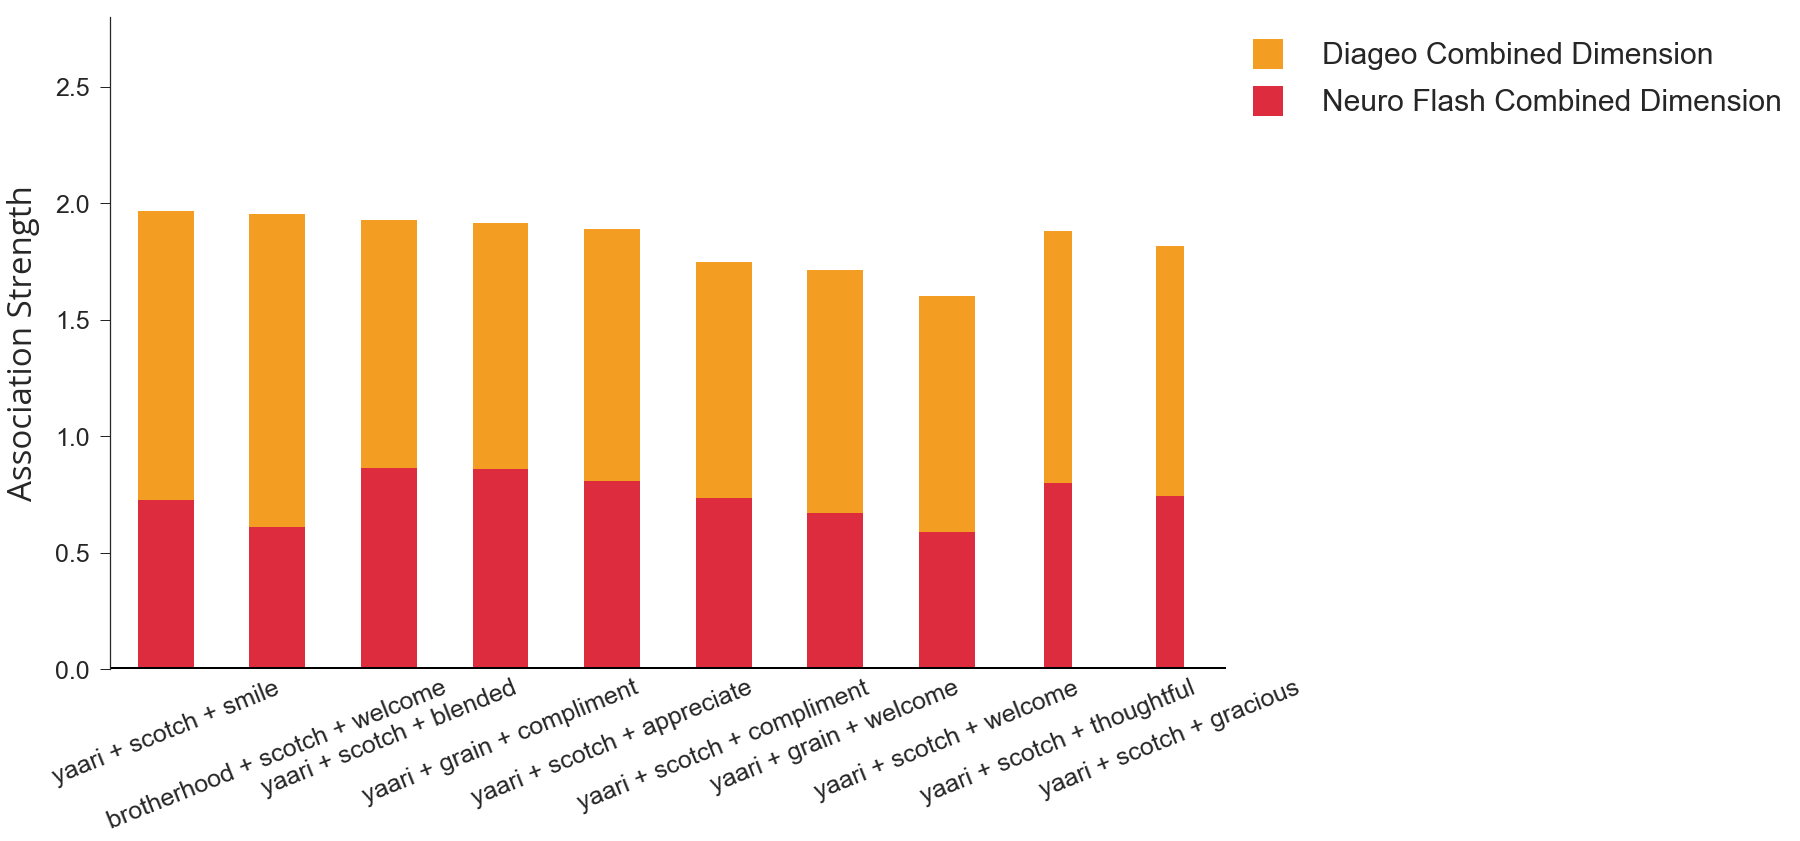

In [905]:
solo_bar_plot(ranked_candidate_stack.tail(10), clustered, 'Overall', orig = False, summed=True)

In [667]:
combinations_all['tokens'] = (combinations_all['brand_myth'].map(lambda x: tokenizer.tokenize(x)[0]) + ' ' + combinations_all['product_ingredients'].map(lambda x: tokenizer.tokenize(x)[0]) + ' ' + combinations_all['product_benefits'].map(lambda x: tokenizer.tokenize(x)[0])).map(lambda x: x.split(' '))

In [668]:
combinations['rank'] = combinations['tokens'].map(lambda words: np.round(np.array([w2r_alt[word] for word in words if word in w2r_alt.keys()]).mean()))

In [828]:
combinations.shape

(40, 10)

In [570]:
combinations_all.sort_values('sum_over_dimensions', ascending=False).he

,brand_myth,product_ingredients,product_benefits,dim_brand_purpose,dim_brand_myth,dim_product_ingredients,dim_product_benefits,dim_appealing,dim_innovative,dim_winner,dim_evolved,sum_over_dimensions
35,brotherhood,grain,warmth,0.304590,0.561214,0.480210,0.397855,0.444065,0.179120,0.059787,0.282609,2.709450
33,brotherhood,grain,wonderful,0.254099,0.563755,0.405331,0.440443,0.466371,0.147800,0.128679,0.302853,2.709330
36,brotherhood,grain,smile,0.333614,0.547818,0.471340,0.427539,0.414723,0.121888,0.132472,0.201052,2.650446
37,brotherhood,grain,thoughtful,0.335703,0.599104,0.355175,0.402590,0.430213,0.153783,0.052750,0.318891,2.648209
32,brotherhood,grain,delight,0.280741,0.578164,0.392223,0.387546,0.448606,0.127991,0.159786,0.260422,2.635480
25,brotherhood,scotch,warmth,0.384132,0.611334,0.384355,0.295453,0.391990,0.115919,0.125708,0.239542,2.548432
31,brotherhood,grain,appreciate,0.310536,0.565170,0.323527,0.396053,0.417478,0.131135,0.108496,0.270423,2.522818
23,brotherhood,scotch,wonderful,0.338396,0.609012,0.303789,0.323187,0.403437,0.081178,0.191801,0.251793,2.502593
39,brotherhood,grain,gracious,0.295283,0.597601,0.355394,0.374912,0.384644,0.115475,0.116683,0.258525,2.498518
34,brotherhood,grain,blended,0.179598,0.504583,0.422775,0.404988,0.363009,0.216663,0.025324,0.363066,2.480007


In [906]:
old_claims = ['Blended with charred American oak cask',
'Matured in american oak barrels and crafted using Solera process',
'33% extra time se Bana Luxury',
'A smooth and easy blend with imported scotch malts',
'Blended with 7 year Old Scotch',
'Grain nahi to Whisky nahi',
'Blended with Scotch and Indian malts',
'A smooth whisky with a finely balanced malt blend',
'Blended with rum of Jamaica Rum']


In [912]:
old_claims = pd.DataFrame(old_claims, columns = ['claim'])

In [914]:
old_claims['tokens'] = old_claims['claim'].map(tokenizer.tokenize)

In [919]:
old_claims['wv'] = old_claims['tokens'].map(lambda x: get_average_vector(x, emb))

In [920]:
old_claims

,claim,tokens,wv
0,Blended with charred American oak cask,"[blend, char, american, oak, cask]","[-0.6283435, 2.2914016, -0.1790612, 0.06653243..."
1,Matured in american oak barrels and crafted us...,"[mature, american, oak, barrel, craft, use, so...","[0.13734774, 2.2156732, 0.29547137, -0.2886087..."
2,33% extra time se Bana Luxury,"[extra, time, se, bana, luxury]","[0.7097107, -0.632454, 0.5040036, -0.6651808, ..."
3,A smooth and easy blend with imported scotch m...,"[smooth, easy, blend, import, scotch, malt]","[-0.04293434, 3.5211391, -1.2464126, 0.1379320..."
4,Blended with 7 year Old Scotch,"[blend, year, old, scotch]","[-0.50162256, 1.3271722, -1.9017916, -0.957857..."
5,Grain nahi to Whisky nahi,"[grain, nahi, whisky, nahi]","[0.52763397, 1.7933972, -1.5884237, 0.20214453..."
6,Blended with Scotch and Indian malts,"[blend, scotch, indian, malt]","[2.0912158, 4.690785, -1.7827562, -0.3709811, ..."
7,A smooth whisky with a finely balanced malt blend,"[smooth, whisky, finely, balance, malt, blend]","[0.49771228, 1.317319, -0.6593161, 0.6094978, ..."
8,Blended with rum of Jamaica Rum,"[blend, rum, jamaica, rum]","[-0.5773163, 0.12922801, 0.15178518, 0.0897264..."


In [925]:
av_wv_old_claims = (old_claims['wv'].values).mean(axis=0)

In [926]:
av_wv_old_claims

array([ 0.24593377,  1.8504069 , -0.7118335 , -0.13075495, -0.12640892,
        0.22294766,  2.64369   , -0.08773333, -0.78698033, -0.7442634 ,
       -0.33067814, -1.3240883 ,  0.12033746, -0.7646414 , -1.0993756 ,
        1.2434173 , -0.15272945,  1.1764505 ,  1.9088732 ,  0.52003884,
        0.14166147,  1.4910586 , -0.23676872, -0.28334415, -0.40905783,
        0.6012069 , -0.62760705, -0.9276035 ,  1.7842969 ,  0.41187117,
       -0.06462222, -0.13657054,  0.32880268,  1.7678857 , -1.238968  ,
       -1.0863042 ,  1.3081346 , -0.11239146,  0.76837784,  0.21438307,
        0.55832154,  0.561465  , -0.5924811 ,  1.3785617 , -0.581901  ,
       -0.7498575 ,  1.144252  ,  0.57888633,  0.3876107 , -1.6326762 ,
       -0.4211432 ,  0.443445  ,  0.07210812,  0.9462573 ,  0.46673182,
        0.35725737,  1.724092  ,  0.77600527,  0.8226016 ,  0.44498184,
       -0.12911588,  1.5433224 ,  0.08887447,  0.4164706 , -0.50965565,
       -0.64325917, -0.07773487, -0.3958593 , -0.42291105, -0.89

In [988]:
claims['wv'].

,claim,tokens,wv,rank,sim_to_av_old
2,Blended with imported scotch and Indian grain ...,"[blend, import, scotch, indian, grain, spirit]","[1.7860141, 5.055079, -0.75358534, -0.79312783...",1.0,0.749171
3,100% Grain 100% Delight 100% Yaari,"[grain, delight, yaari]","[0.54252845, 2.4519606, 0.40312514, -1.1404891...",2.0,0.516061
4,yaari made richer,"[yaari, rich]","[-0.55660367, 2.235842, -0.23943049, -0.687845...",2.0,0.331261
0,No1 Yaari ka No1 Spirit,"[yaari, ka, spirit]","[0.5001866, 0.6641873, -1.4467922, -0.74694806...",1.0,0.277231
1,100% Grain Hi Hai Original Ki Pehchaan,"[grain, hello, hai, original, ki, pehchaan]","[0.09837947, -1.1806262, -2.3887413, 1.5436647...",1.0,0.238689


In [987]:
claims.set_index('claim')['sim_to_av_old'].sort

claim
Blended with imported scotch and Indian grain spirit    0.749171
100% Grain 100% Delight 100% Yaari                      0.516061
yaari made richer                                       0.331261
No1 Yaari ka No1 Spirit                                 0.277231
100% Grain Hi Hai Original Ki Pehchaan                  0.238689
Name: sim_to_av_old, dtype: float64

In [928]:
claims['sim_to_av_old'] = claims['wv'].map(lambda x: cosine_similarity(x, av_wv_old_claims))

In [935]:
claims = claims.sort_values('sim_to_av_old', ascending=False)

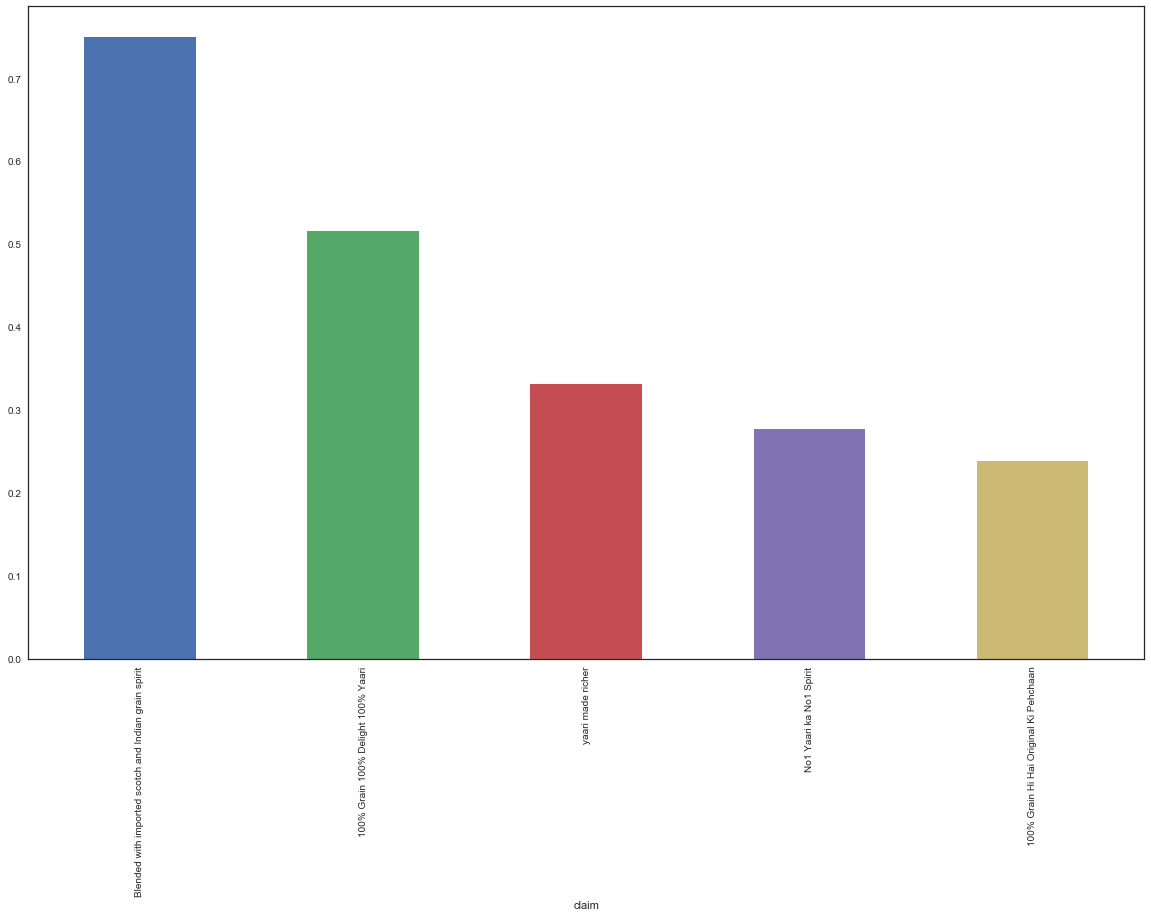

In [937]:
plt.figure(figsize=(20, 12))
claims.set_index('claim')['sim_to_av_old'].plot.bar()